In [1]:
import pywt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops_table
import pandas as pd
import napari
from napari.utils import nbscreenshot
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import RandomForestClassifier
from dtaidistance import dtw, preprocessing
from collections import defaultdict
from scipy.sparse import csr_matrix

## Random Composite Signal Generation

In [2]:
seed = 42
np.random.seed(seed)


n_samples = 500
freq = 5
time = np.linspace(0, 1, n_samples)

* Signal1: gaussian
* Signal2: Cardiac AP
* Signal3: Decreasing Monoexponential

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_19116\2929572496.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  signal1 = signal.gaussian(30, std=3)


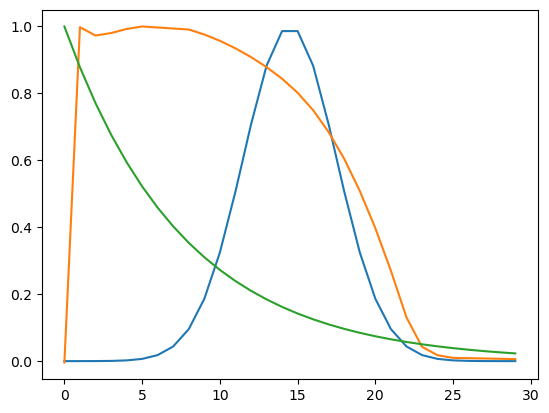

In [3]:
# Signal1: Gaussian
signal1 = signal.gaussian(30, std=3)

# Signal2: Cardiac Ventricular Action Potential
AP_original = np.loadtxt(r"C:\Users\mazo260d\Documents\GitHub\metroid\Simulated_Data\AP.txt",delimiter='\t')
time_sub = np.linspace(0, 5, n_samples) #time vector

# Re-sample at a constant sampling frequency
AP_original[:,0] = AP_original[:,0]/1000                       #ms to sec
xvals = np.arange(AP_original[0,0], AP_original[-1,0], 0.0001) #generate a time vetor with a constant sampling frequency
yinterp = np.interp(xvals, AP_original[:,0], AP_original[:,1]) #interpolate values where original AP time data is missing

# Re-sample by number of samples
yinterp1 = np.interp(time_sub, xvals, yinterp)   #interpolate (extend) data to whole time vector
# Normalize
signal2 = yinterp1
signal2 = signal2+abs(signal2[-1])                          #shift amp from ~-80 to 0
signal2 = signal2/np.amax(signal2)                          #normalize amplitude
# Crop
signal2 = signal2[:30]

# Signal3: Decreasing Monoexponential
def monoexp(x, a, b):
    return a * np.exp(-b * x)
b=0.13
a=1
x = np.arange(30)
signal3 = monoexp(x, a, b)

signals_dict = {0: signal1,
                1: signal2,
                2: signal3}

plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)

## Make a random signal composition by adding the three signals with random amplitudes and time shifts

In [4]:
def generate_random_signal_composition(signals_dict, n_samples=500, min_gap=5, max_gap=100):
    composite_signal = np.zeros(n_samples)
    
    position = 0
    while position < n_samples:
        start = position
        # width = np.random.randint(min_width, max(min(max_width, n_samples - position), min_width + 1) + 1)
        signal = signals_dict[np.random.randint(low=0, high=len(signals_dict))]
        width = min(len(signal), n_samples - position)
        composite_signal[start:start+width] = signal[:width]
        position += width + np.random.randint(min_gap, max_gap)  # Move to the end of that window and add some space

    return composite_signal

In [5]:
composite_signal = generate_random_signal_composition(signals_dict=signals_dict)

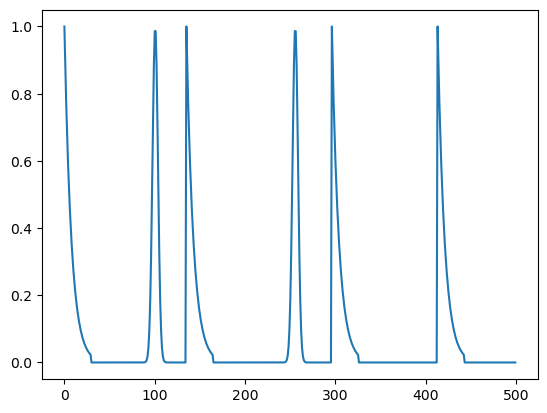

In [6]:
plt.plot(composite_signal)

## Generate random objects

In [7]:
# Generate objects

disk = morphology.disk(4)
square = morphology.square(9)
square[square == 1] = 2
diamond = morphology.diamond(4)
diamond[diamond == 1] = 3
objects_list = [disk, square, diamond]
image = np.zeros((100, 100))
object_order = []
for i in range(10):
    for j in range(3):
        n = np.random.randint(low=2, high=5)
        # obj = objects_list[n]
        obj = morphology.disk(n)
        image[i * 10: i * 10 + (n*2 + 1), 20 + j * 20: 20 + j * 20 + (n*2 + 1)] = obj
        object_order.append(n)

## Add composite signals to objects

In [8]:
# Add signals to label image

label_image = label(image)
height, width = image.shape
time_points = n_samples
time_lapse = np.zeros((time_points, height, width))
for i in range(label_image.max()):
    # print(object_order[i])
    # for label in [1, 2, 3]:
    mask = (label_image == i + 1)  # create boolean mask for current label
    # current_signal = signals[object_order[i]]  # get corresponding signal for current label
    current_signal_category = generate_random_signal_composition(signals_dict)

    # Add random phase by shifting signal
    random_shift = np.random.random()
    current_signal_category = np.roll(current_signal_category, int(random_shift * len(current_signal_category)))

    
    # Add random offset
    current_signal_category = current_signal_category + np.random.random() * 5

    # # Add random window pulses
    # random_windows = generate_random_window_mask()
    # current_signal[~random_windows] = 0

    # Add random noise
    current_signal_category = current_signal_category + np.random.random(size=len(current_signal_category)) / 10

    time_lapse[:, mask] = current_signal_category.reshape((time_points, -1))  # assign signal to region corresponding to current label

## Add mean_intensities of random objects over time to a table

In [9]:
df = pd.DataFrame([])
for i in range(time_points):
    features = regionprops_table(label_image, intensity_image=time_lapse[i], properties=('label', 'mean_intensity'))
    features['frame'] = i
    # data = features.values()
    df = pd.concat([df, pd.DataFrame(features)])

In [10]:
df

,label,mean_intensity,frame
0,1,3.477317,0
1,2,2.538447,0
2,3,1.398264,0
3,4,0.913758,0
4,5,0.505126,0
...,...,...,...
25,26,3.999081,499
26,27,0.277202,499
27,28,0.559926,499
28,29,3.634906,499


## Add data to napari

In [11]:
# viewer = napari.Viewer()
# averages = np.mean(time_lapse, axis=(1, 2))
# viewer.add_image(time_lapse, name='time-lapse')
# table = df

# viewer.add_labels(label_image, features=table, name='labels')

## Annotate some signals

![](./screenshots/signal_annotations1.png)

![](./screenshots/signal_annotations2.png)

In [12]:
# nbscreenshot(viewer)

In [13]:
# nbscreenshot(viewer)

## Save table with annotations to disk

In [14]:
# table = viewer.layers[-1].features

# table.to_csv('table_with_annotations.csv')

table = pd.read_csv('table_with_annotations.csv')
table

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,1,2,2.538447,0,0
2,2,3,1.398264,0,0
3,3,4,0.913758,0,0
4,4,5,0.505126,0,0
...,...,...,...,...,...
14995,14995,26,3.999081,499,0
14996,14996,27,0.277202,499,0
14997,14997,28,0.559926,499,0
14998,14998,29,3.634906,499,0


## Get training data

Get labels where some annotations are present

In [15]:
annotations_mask = table['Annotations'] != 0
labels_with_annotations = np.unique(table[annotations_mask]['label'].values)
labels_with_annotations

array([1, 2, 3], dtype=int64)

In [16]:
# get table rows where label matches labels_with_annotations
table_training = table[table['label'].isin(labels_with_annotations)].sort_values(by=['label', 'frame']).reset_index(drop=True).iloc[:, 1:]
table_training

,label,mean_intensity,frame,Annotations
0,1,3.477317,0,0
1,1,3.499637,1,0
2,1,3.433654,2,0
3,1,3.455424,3,0
4,1,3.434541,4,0
...,...,...,...,...
1495,3,1.375912,495,0
1496,3,1.394512,496,0
1497,3,1.449024,497,0
1498,3,1.435429,498,0


## Extract Sub-Signals

In [199]:
# class SubSignal:
#     def __init__(self, data, category, label, start_frame, end_frame):
#         self.data = data  # The signal data
#         self.category = category  # The class/annotation of the signal
#         self.label = label  # The label of the signal
#         self.start_frame = start_frame  # The starting frame of the signal segment
#         self.end_frame = end_frame  # The ending frame of the signal segment

#     def __repr__(self):
#         return f"<SignalSegment category={self.category}, label={self.label}, frames=[{self.start_frame}:{self.end_frame}), data_length={len(self.data)}>"

# class SubSignalCollection:
#     def __init__(self):
#         self.sub_signals = []
#         self.categories = []
#         self.max_length_per_category = defaultdict(int)

#     def add_sub_signal(self, sub_signal):
#         self.sub_signals.append(sub_signal)
#         if sub_signal.category not in self.categories:
#             self.categories.append(sub_signal.category)
#         self.max_length_per_category[sub_signal.category] = max(self.max_length_per_category[sub_signal.category], len(sub_signal.data))
    
#     def __repr__(self):
#         return f"<SubSignalCollection signal categories={self.categories}, number of signals={len(self.sub_signals)}>"
    
#     def sort_by_category(self):
#         self.sub_signals = sorted(self.sub_signals, key=lambda x: x.category)

class SubSignal:
    _id_counter = 0  # Class variable to keep track of the last assigned ID
    def __init__(self, data, category, label, start_frame, end_frame):
        self.data = data  # The signal data as a numpy array
        self.category = category  # The class/annotation of the signal
        self.label = label  # The label of the signal
        self.start_frame = start_frame  # The starting frame of the signal segment
        self.end_frame = end_frame  # The ending frame of the signal segment
        self.id = SubSignal._get_next_id()  # Assign a unique ID

    @classmethod
    def _get_next_id(cls):
        cls._id_counter += 1
        return cls._id_counter

    def __repr__(self):
        return f"<SignalSegment id={self.id}, category={self.category}, label={self.label}, frames=[{self.start_frame}:{self.end_frame}), data_length={len(self.data)}>"

    def to_slice(self):
        return slice(self.start_frame, self.end_frame)

    def overlaps(self, other, threshold):
        range1 = set(range(self.start_frame, self.end_frame))
        range2 = set(range(other.start_frame, other.end_frame))
        intersection = len(range1.intersection(range2))
        union = len(range1.union(range2))
        jaccard_index = intersection / union if union else 0
        return jaccard_index > threshold

    def merge(self, other):
        new_start_frame = min(self.start_frame, other.start_frame)
        new_end_frame = max(self.end_frame, other.end_frame)
        new_length = new_end_frame + 1 - new_start_frame

        new_data = np.zeros(new_length)
        # Place the current data in the new_data array
        new_data[self.start_frame - new_start_frame:self.end_frame + 1 - new_start_frame] = self.data
        
        # Calculate the slice for the other data
        other_slice_start = other.start_frame - new_start_frame
        other_slice_end = other.end_frame + 1 - new_start_frame

        # Ensure the slices are correctly aligned
        new_data[other_slice_start:other_slice_end] = other.data

        self.data = new_data
        self.start_frame = new_start_frame
        self.end_frame = new_end_frame
        self.id = SubSignal._get_next_id()  # Assign a new unique ID to the merged result

    def interpolate_samples(self, n_samples):
        # Resample the signal segment to a fixed number of samples using spline interpolation
        x = np.arange(len(self.data))
        x_new = np.linspace(0, len(self.data), n_samples)
        spline = make_interp_spline(x, self.data, k=3)
        return spline(x_new)

class SubSignalCollection:
    def __init__(self):
        self.sub_signals = []
        self.categories = []
        self.max_length_per_category = defaultdict(int)

    def add_sub_signal(self, sub_signal):
        self.sub_signals.append(sub_signal)
        if sub_signal.category not in self.categories:
            self.categories.append(sub_signal.category)
        self.max_length_per_category[sub_signal.category] = max(self.max_length_per_category[sub_signal.category], len(sub_signal.data))
    
    def __repr__(self):
        return f"<SubSignalCollection signal categories={self.categories}, number of signals={len(self.sub_signals)}>"

    def sort_by_category(self):
        self.sub_signals = sorted(self.sub_signals, key=lambda x: x.category)

    def merge_subsignals(self, threshold):
        merged = []
        for subsignal in self.sub_signals:
            merged_with_existing = False
            for m in merged:
                if subsignal.label == m.label and subsignal.overlaps(m, threshold): # and subsignal.category != m.category
                    m.merge(subsignal)
                    m.category = f"{m.category}-{subsignal.category}"
                    merged_with_existing = True
                    break
            if not merged_with_existing:
                merged.append(subsignal)
        self.sub_signals = merged
    

def extract_sub_signals_by_annotations(df, column_signal_value, column_signal_id, column_signal_annotation, column_frame):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the signal data.
    column_signal_value : str
        The column name containing the signal data.
    column_signal_id : str
        The column name containing the signal ID (usually the label from image).
    column_signal_annotation : str
        The column name containing the signal annotations.
    column_frame : str
        The column name containing the frame information (time).
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    data = df[column_signal_value].values
    annotations = df[column_signal_annotation].values
    labels = df[column_signal_id].values
    frames = df[column_frame].values
    return extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames)

# The code below is much slower, it is best to get array and process them than using the DataFrame directly
    # sub_signal_collection = SubSignalCollection()
    # current_signal_category = 0
    # start_index = None
    # annotations = df[column_signal_annotation].values

    # # for i, row in df.iterrows():
    # for i, ann in enumerate(annotations):
    #     if ann > 0:  # Signal detected
    #         if current_signal_category == 0:  # New signal starts
    #             current_signal_category = ann
    #             start_index = i
    #         elif current_signal_category != ann:  # Different signal detected, save previous
    #             # Adjusted to include label and frame information
    #             sub_signal = SubSignal(df[column_signal_value].iloc[start_index:i].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[i])
    #             sub_signal_collection.add_sub_signal(sub_signal)
                
    #             current_signal_category = ann
    #             start_index = i
    #     else:  # Noise detected, save previous signal
    #         if current_signal_category > 0:
    #             sub_signal = SubSignal(df[column_signal_value].iloc[start_index:i].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[i])
    #             sub_signal_collection.add_sub_signal(sub_signal)
                
    #             current_signal_category = 0
    #             start_index = None
    
    # # Handle the case where the last signal goes until the end
    # if current_signal_category > 0:
    #     sub_signal = SubSignal(df[column_signal_value].iloc[start_index:].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[-1])
    #     sub_signal_collection.add_sub_signal(sub_signal)
    
    # return sub_signal_collection

def extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    data : np.ndarray
        The signal data array.
    annotations : np.ndarray
        The annotations array.
    labels : np.ndarray
        The labels array.
    frames : np.ndarray
        The frames array.
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    sub_signal_collection = SubSignalCollection()
    sub_signals_list = []
    current_signal_category = 0
    start_index = None

    for i, ann in enumerate(annotations):
        if ann > 0:  # Signal detected
            if current_signal_category == 0:  # New signal starts
                current_signal_category = ann
                start_index = i
            elif current_signal_category != ann:  # Different signal detected, save previous
                # Adjusted to include label and frame information
                sub_signal = SubSignal(data[start_index:i], 
                                       current_signal_category, 
                                       labels[start_index], 
                                       frames[start_index], 
                                       frames[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal_category = ann
                start_index = i
        else:  # Noise detected, save previous signal
            if current_signal_category > 0:
                sub_signal = SubSignal(data[start_index:i],
                                       current_signal_category,
                                       labels[start_index],
                                       frames[start_index],
                                       frames[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal_category = 0
                start_index = None
    
    # Handle the case where the last signal goes until the end
    if current_signal_category > 0:
        sub_signal = SubSignal(data[start_index:],
                               current_signal_category,
                               labels[start_index],
                               frames[start_index],
                               frames[-1])
        sub_signal_collection.add_sub_signal(sub_signal)
    
    return sub_signal_collection


In [200]:
# Optional small test
# data1 = np.array([0, 1, 2, 0, 0, 3, 4, 5, 0, 6, 0, 1, 2, 0, 0, 0, 6, 0]) # intensity values
# annotations1 = np.array([0, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 1, 0, 0, 0, 3, 0])
# label1 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2])
# frame1 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])
# df = pd.DataFrame({'mean_intensity': data1, 'Annotations': annotations1, 'label': label1, 'frame': frame1})

In [201]:
data = table_training['mean_intensity'].values
annotations = table_training['Annotations'].values
labels = table_training['label'].values
frames = table_training['frame'].values

In [202]:
%%timeit
sub_signal_collection = extract_sub_signals_by_annotations(table_training, 'mean_intensity', 'label', 'Annotations', 'frame')

333 µs ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [203]:
%%timeit
sub_signal_collection = extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames)

261 µs ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [204]:
sub_signal_collection_train = extract_sub_signals_by_annotations(table_training, 'mean_intensity', 'label', 'Annotations', 'frame')
sub_signal_collection_train

<SubSignalCollection signal categories=[1, 2, 3], number of signals=17>

## Calculate features for each annotated signal and put them in a table

Sub_signals may have different lengths depending on the user annotations.

In [205]:
n_samples = max(sub_signal_collection_train.max_length_per_category.values())
n_samples

32

In [206]:
# sub_signal_collection.sub_signals

Use spline interpolation to make all sub_signals have the same length under the corresponding category.
Put resampled signals in a table.

In [207]:
# def interpolate_samples(signal, n_samples):
#     # Resample the signal segment to a fixed number of samples using spline interpolation
#     x = np.arange(len(signal))
#     x_new = np.linspace(0, len(signal), n_samples)
#     spline = make_interp_spline(x, signal, k=3)
#     return spline(x_new)

In [208]:
table_training_resampled = pd.DataFrame([])
for i, sub_signal in enumerate(sub_signal_collection_train.sub_signals):
    sub_table = pd.DataFrame(sub_signal.interpolate_samples(n_samples), columns=['mean_intensity_interpolated'])
    # sub_table = pd.DataFrame(interpolate_samples(sub_signal.data, sub_signal_collection.max_length_per_category[sub_signal.category]), columns=['mean_intensity_interpolated'])
    sub_table['sub_label'] = sub_signal.id# i + 1
    sub_table['original_label'] = sub_signal.label
    sub_table['original_start_frame'] = sub_signal.start_frame
    sub_table['original_end_frame'] = sub_signal.end_frame
    sub_table['frame_resampled'] = np.linspace(sub_signal.start_frame, sub_signal.end_frame, n_samples)
    sub_table['category'] = sub_signal.category

    table_training_resampled = pd.concat([table_training_resampled, sub_table], axis=0)
table_training_resampled

,mean_intensity_interpolated,sub_label,original_label,original_start_frame,original_end_frame,frame_resampled,category
0,3.453399,275775,1,43,74,43.0,1
1,3.479164,275775,1,43,74,44.0,1
2,4.480783,275775,1,43,74,45.0,1
3,4.448369,275775,1,43,74,46.0,1
4,4.424114,275775,1,43,74,47.0,1
...,...,...,...,...,...,...,...
27,1.428026,275791,3,448,479,475.0,2
28,1.494664,275791,3,448,479,476.0,2
29,1.482570,275791,3,448,479,477.0,2
30,1.415668,275791,3,448,479,478.0,2


## Extract sub_signal features

use tsfresh to generate sub_signal features table

In [209]:
# tsfresh syntax for extracting features
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

table_training_resampled_minimal = table_training_resampled[['mean_intensity_interpolated', 'sub_label', 'frame_resampled']]

extraction_settings = ComprehensiveFCParameters()

signal_features_table_training = extract_features(table_training_resampled_minimal, column_id='sub_label', column_sort='frame_resampled',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


In [210]:
signal_features_table_training

,mean_intensity_interpolated__variance_larger_than_standard_deviation,mean_intensity_interpolated__has_duplicate_max,mean_intensity_interpolated__has_duplicate_min,mean_intensity_interpolated__has_duplicate,mean_intensity_interpolated__sum_values,mean_intensity_interpolated__abs_energy,mean_intensity_interpolated__mean_abs_change,mean_intensity_interpolated__mean_change,mean_intensity_interpolated__mean_second_derivative_central,mean_intensity_interpolated__median,...,mean_intensity_interpolated__fourier_entropy__bins_5,mean_intensity_interpolated__fourier_entropy__bins_10,mean_intensity_interpolated__fourier_entropy__bins_100,mean_intensity_interpolated__permutation_entropy__dimension_3__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_4__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_5__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_6__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_7__tau_1,mean_intensity_interpolated__query_similarity_count__query_None__threshold_0.0,mean_intensity_interpolated__mean_n_absolute_max__number_of_maxima_7
275775,0.0,0.0,0.0,0.0,128.659991,522.925502,0.081638,0.000426,-0.000185,4.193197,...,0.223718,0.578325,0.871781,1.514278,2.237126,2.682016,2.885083,3.044820,0.0,4.476254
275776,0.0,0.0,0.0,0.0,119.999916,452.596621,0.088432,-0.003723,-0.003527,3.652348,...,0.223718,0.443757,0.885289,1.436829,2.195649,2.576443,2.791342,2.844614,0.0,4.202124
275777,0.0,0.0,0.0,0.0,121.322724,463.977564,0.076574,-0.008784,-0.003394,3.633539,...,0.659872,0.659872,0.871781,1.187224,1.574207,1.973865,2.165260,2.308761,0.0,4.341924
275778,0.0,0.0,0.0,0.0,118.658982,442.293133,0.082028,0.005648,0.003175,3.607866,...,0.223718,0.223718,0.885289,1.477087,2.220018,2.642169,2.936427,3.131334,0.0,4.144616
275779,0.0,0.0,0.0,0.0,121.178887,463.035629,0.077698,-0.008034,-0.002966,3.620959,...,0.659872,0.659872,0.871781,1.383562,1.920546,2.309739,2.499499,2.639082,0.0,4.364678
275780,0.0,0.0,0.0,0.0,130.225233,535.638883,0.083426,-0.005562,-0.001356,4.296854,...,0.443757,0.443757,0.871781,1.004099,1.342574,1.474108,1.511962,1.551888,0.0,4.484893
275781,0.0,0.0,0.0,0.0,127.741764,515.859213,0.079952,-0.001402,-0.000553,4.116691,...,0.443757,0.659872,0.871781,1.534027,2.334285,2.738078,2.791342,2.844614,0.0,4.452759
275782,0.0,0.0,0.0,0.0,93.727501,278.648197,0.072188,0.003474,0.001715,2.809412,...,0.659872,0.659872,0.871781,1.320852,1.779306,2.031828,2.175211,2.320715,0.0,3.470990
275783,0.0,0.0,0.0,0.0,99.674720,316.317221,0.096000,-0.004351,-0.003514,3.302937,...,0.443757,0.443757,0.871781,1.526806,2.081999,2.340664,2.443028,2.497519,0.0,3.554332
275784,0.0,0.0,0.0,0.0,91.242449,264.465096,0.077226,-0.006403,-0.003032,2.687080,...,0.659872,0.659872,0.871781,1.053210,1.423496,1.683923,1.826897,1.973620,0.0,3.444199


Annotations are signal categories

In [211]:
annotations = [sub_sig.category for sub_sig in sub_signal_collection_train.sub_signals]
annotations


[1, 2, 3, 2, 3, 1, 1, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2]

### Train Classifier

In [212]:
random_state = 42
classifier = RandomForestClassifier(random_state=random_state)
classifier_path = 'sub_signal_classifier.pkl'

# X_train = signal_features_table_training.iloc[:, 1:] # remove the first column (the object_id)

# # imput mean to handle NaN values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=False)
# X_imputed_train = imputer.fit_transform(X_train)

classifier.fit(signal_features_table_training, annotations)

train_score = classifier.score(signal_features_table_training, annotations)
print(train_score)

1.0


## Detect regions of interest

### Generate a template per category/annotation from the training data.

**For the alignment, consider applying derivative plus low-pass from dtw if signals have non-flat offsets. (check example [here](https://dtaidistance.readthedocs.io/en/latest/usage/clustering.html#k-means-dba-clustering))**

In [213]:
def normalize(signal, method='minmax'):
    if method == 'zscore':
        return (signal - np.mean(signal)) / np.std(signal)
    elif method == 'minmax':
        return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    else:
        raise ValueError(f"Unknown normalization method: {method}")

def align_signals(reference, signal, detrend=False, smooth=0.1):
    if detrend:
        signal_warp = preprocessing.differencing(signal, smooth=smooth)
        reference_warp = preprocessing.differencing(reference, smooth=smooth)
    else:
        signal_warp = signal
        reference_warp = reference
    alignment = dtw.warping_path_fast(reference_warp, signal_warp)
    
    aligned_signal = np.zeros_like(reference)
    for (i, j) in alignment:
        aligned_signal[i] = signal[j]
    return aligned_signal

# Function to generate template from replicates using median signal as reference
def generate_template_mean(replicates, plot_results=False, detrend=False, smooth=0.1):

    # Use the median signal as the initial reference
    median_signal = np.median(replicates, axis=0)
    
    # Align all replicates to the median signal
    aligned_replicates = [align_signals(median_signal, rep, detrend, smooth) for rep in replicates]
    # Optionally plot alignment results
    if plot_results:
        fig, ax = plt.subplots()
        for i, arep, rep in zip(range(len(aligned_replicates)), aligned_replicates, replicates):
            if i != len(aligned_replicates) - 1:
                ax.plot(rep, alpha=0.5, color='gray')
                ax.plot(arep, alpha=0.5, color='cyan')
            else:
                ax.plot(rep, alpha=0.5, color='gray', label='replicate')
                ax.plot(arep, alpha=0.5, color='cyan', label='aligned_replicate')
    # Compute the average to form the template
    template = np.mean(aligned_replicates, axis=0)
    if plot_results:
        ax.plot(template, alpha=0.5, color='magenta', label='template_mean', lw=4)
        plt.legend()
    return template

def generate_templates_by_category(sub_signal_collection, plot_results=False, detrend=False, smooth=0.1):
    """
    Generate templates by category from a list of SignalSegment objects.
    
    Parameters
    ----------
    sub_signal_collection : SubSignalCollection
        The collection of signal segments.

    """
    # Sort the signal segments by category
    sub_signal_collection.sort_by_category()
    
    # Initialize variables
    templates_by_category = {}
    current_category = None
    sub_signals_with_current_category = []
    n_samples = max(sub_signal_collection.max_length_per_category.values())

    # Process each signal segment
    for sub_signal in sub_signal_collection.sub_signals:
        if sub_signal.category != current_category:
            # If the category changes, process the current category
            if sub_signals_with_current_category:
                template = generate_template_mean(sub_signals_with_current_category, plot_results, detrend, smooth)
                templates_by_category[current_category] = template
                sub_signals_with_current_category = []

            # Update the current category
            current_category = sub_signal.category

        # Normalize and resample the current segment
        # target_length = sub_signal_collection.max_length_per_category[current_category]
        resampled_norm_data = normalize(sub_signal.interpolate_samples(n_samples), method='zscore')
        sub_signals_with_current_category.append(resampled_norm_data)
    
    # Process the last category
    if sub_signals_with_current_category:
        template = generate_template_mean(sub_signals_with_current_category, plot_results, detrend, smooth)
        templates_by_category[current_category] = template

    return templates_by_category

Benchmark generate_template functions

In [214]:
replicates_for_benchmark = [normalize(sub_signal.interpolate_samples(n_samples)) for sub_signal in sub_signal_collection_train.sub_signals if sub_signal.category == 1]

In [215]:
%%timeit
generate_template_mean(replicates_for_benchmark, plot_results=False)

249 µs ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


generate template function is quite slow (PCA approach deforms signals)

Plot templates and compare them to the original signals
1. If detrend is True, align by derivative plus low-pass (only useful if sub_signals have a trending baseline)
2. If detrend is Fals, align replicates directly

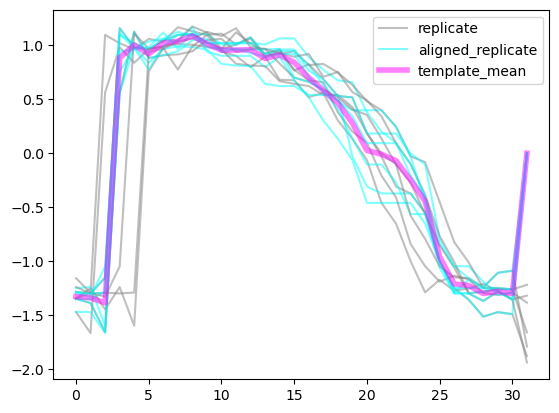

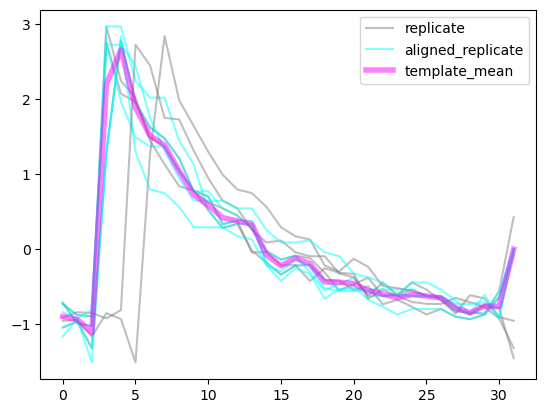

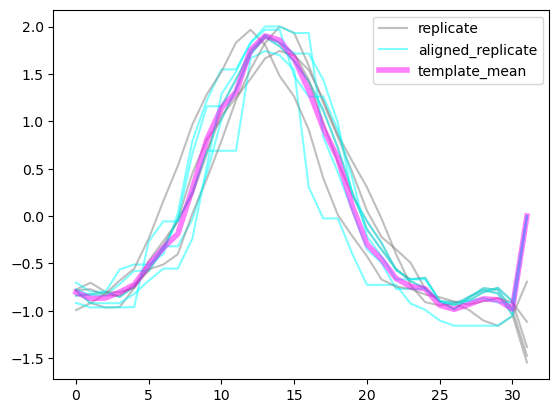

In [216]:
sub_signal_templates = generate_templates_by_category(sub_signal_collection_train, plot_results=True, detrend=True, smooth=0.45)

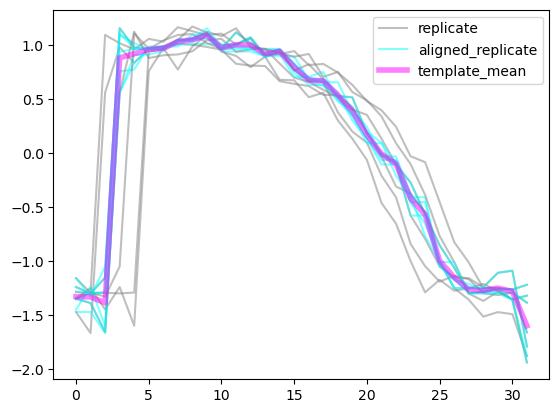

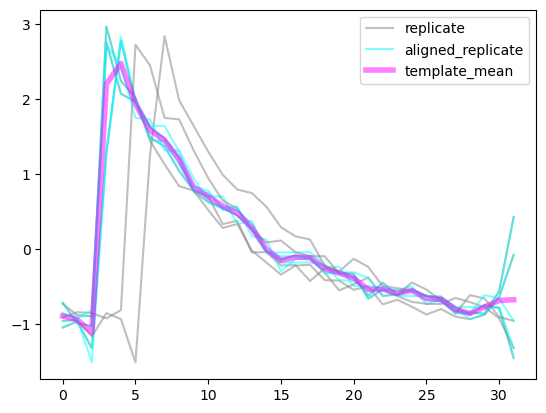

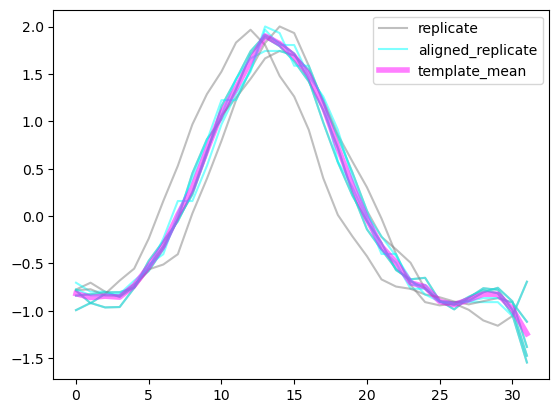

In [217]:
sub_signal_templates = generate_templates_by_category(sub_signal_collection_train, plot_results=True, detrend=False)

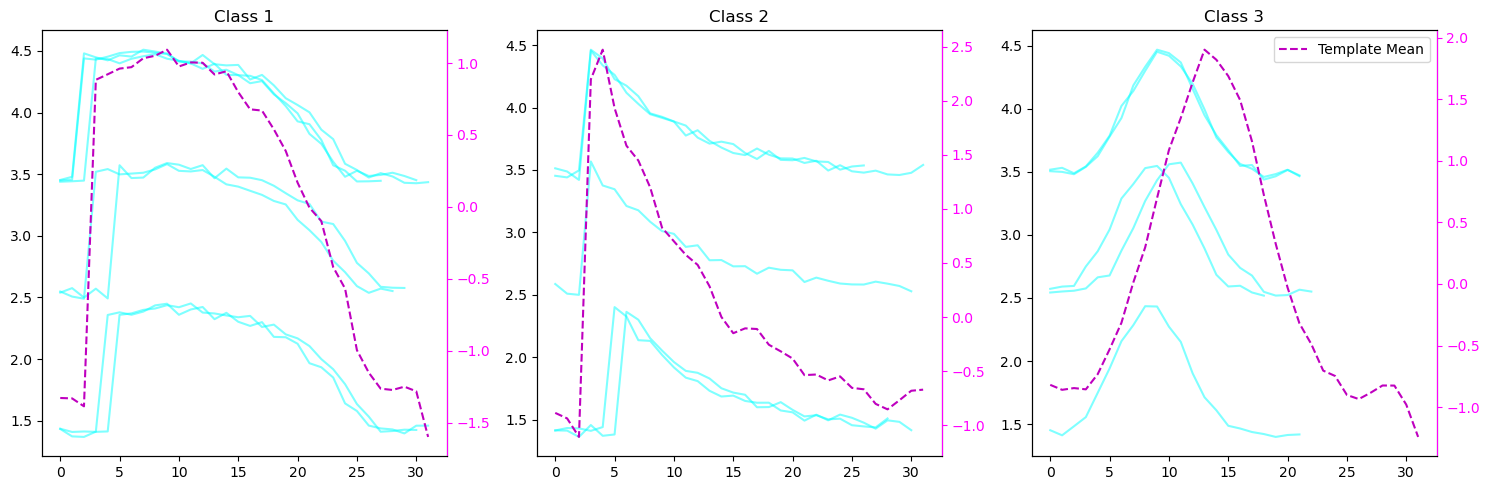

In [218]:
# Plot all signals separated by class in a different column
fig, ax = plt.subplots(1, len(sub_signal_templates), figsize=(15, 5))
for sub_sig in sub_signal_collection_train.sub_signals:
    ax[sub_sig.category-1].plot(sub_sig.data, 'cyan', alpha=0.5)
    ax[sub_sig.category-1].set_title(f'Class {sub_sig.category}')

for i, template_mean in sub_signal_templates.items():
    ax2 = ax[i-1].twinx()
    ax2.yaxis.label.set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    ax2.spines['right'].set_color('magenta')
    ax2.plot(template_mean, 'm--', label='Template Mean')
ax2.legend()
plt.tight_layout()

## Detect regions of interest
Find peaks by thresholding cross-correlation and get a region around them.
Develop some strategy to collect these regions without duplication (or collect duplication, but assign some weight or probability to them)


In [273]:
chosen_label = 6
# in label 10, same class (1) overlaps because sub_signals are too close to each other
# in label 11, same class (3) is detected by two signals that are too close to each other
# in label 6, there is some noise that makes the same sub_signal to be detected twice by the same class with a small shift

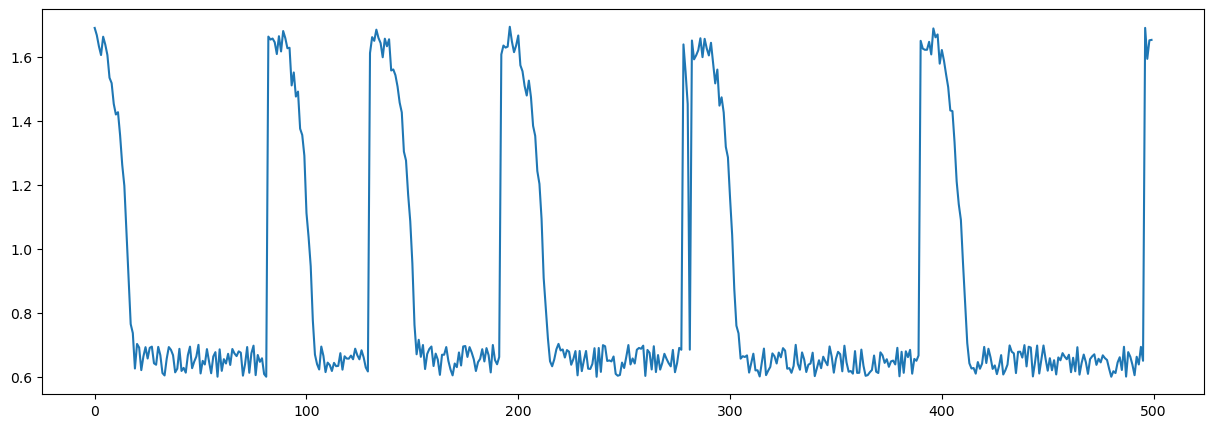

In [274]:
composite_signal1 = table[(table['label'] == chosen_label)].sort_values(by=['label', 'frame']).reset_index(drop=True)['mean_intensity'].values
plt.figure(figsize=(15, 5))
plt.plot(composite_signal1)

Calculate cross-correlation between each normalized signal class and whole normalized annotated composite signal and plot results

In [275]:
sub_signal_collection_train.categories

[1, 2, 3]

In [276]:
len(sub_signal_templates)

3

Next steps:
- check whether this is enough to ID sub_signals (no Random Forest Classifier), but it seems not (it detects more sub_signals per category, check the exponential example below, maybe thresholding it differently could solve it)
- if not, train a classifier to detect sub_signals and find a way to assign unique classes to them
- try wavelet transform to detect sub_signals as an alternative to both methods above

Found 7 peaks for class 1
Found 5 peaks for class 2
Found 5 peaks for class 3


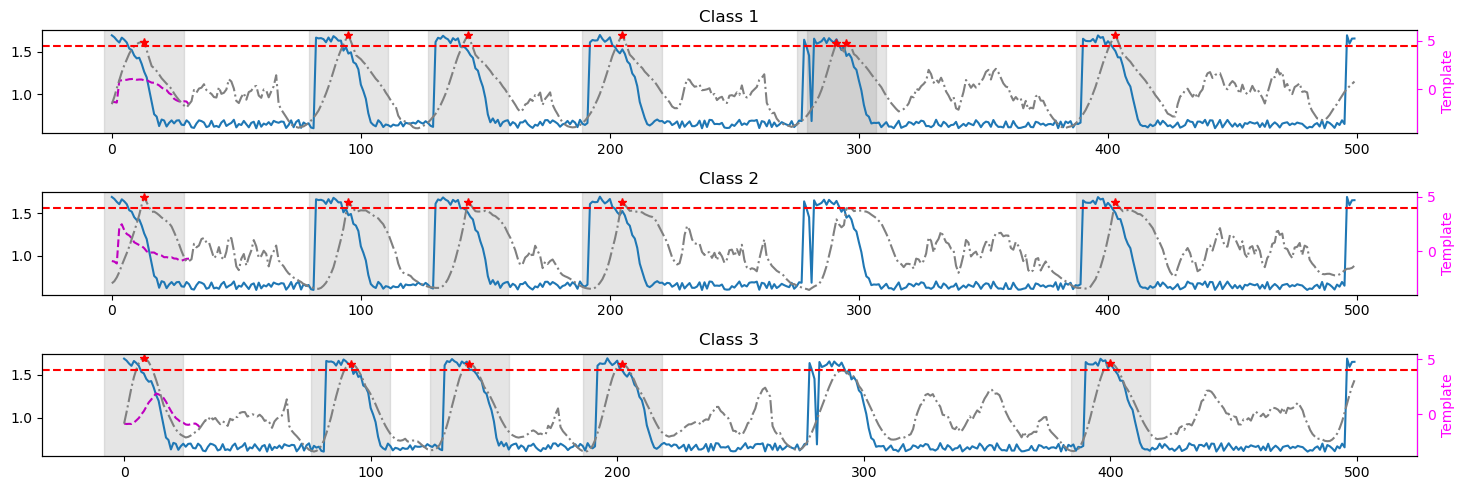

In [333]:
def detect_sub_signal_by_template(composite_signal, template, threshold, return_cross_corr=False, norm_method='minmax'):
    signal_norm = normalize(composite_signal, method=norm_method)
    template_norm = normalize(template, method=norm_method)
    cross_corr = signal.correlate(signal_norm, template_norm, mode='same') # default method already chooses between fft and direct

    if norm_method == 'minmax':
         # Normalizing cross-correlation by minmax directly
        normalized_corr = normalize(cross_corr, method=norm_method)
    elif norm_method == 'zscore':
        # Normalizing cross-correlation by energy of signal and template
        fm2 = signal.correlate(signal_norm**2, np.ones_like(template_norm), mode='same') # Convolution of the squared composite signal with a window of ones
        fm = signal.correlate(signal_norm, np.ones_like(template_norm), mode='same') # Convolution of the composite signal with a window of ones
        n = len(template)
        denominator = np.sqrt(fm2 - fm**2/n)
        normalized_corr = cross_corr/denominator

    threshold = np.max(normalized_corr) * threshold
    peaks_indices, _ = signal.find_peaks(normalized_corr, height=threshold)
    if return_cross_corr:
        return peaks_indices, normalized_corr
    return peaks_indices

threshold=0.8
fig, ax = plt.subplots(len(sub_signal_templates),1, figsize=(15, 5))
for i, sub_signal in enumerate(sub_signal_templates.values()):
    peaks_indices, normalized_cross_corr = detect_sub_signal_by_template(composite_signal1, sub_signal, threshold, return_cross_corr=True, norm_method='zscore')
    ax[i].plot(composite_signal1, label='Composite Signal')
    ax2 = ax[i].twinx()
    ax2.plot(sub_signal, 'm--', label='Template')
    ax2.yaxis.label.set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    ax2.spines['right'].set_color('magenta')
    ax2.set_ylabel('Template', color='magenta')
    ax2.plot(normalized_cross_corr, '-.', color='gray', label='Normalized Cross-Correlation')
    ax2.plot(peaks_indices, normalized_cross_corr[peaks_indices], 'r*', label='Detected Peaks')
    ax2.axhline(y=np.max(normalized_cross_corr)*threshold, color='r', linestyle='--')
    for peak_index in peaks_indices:
        ax[i].axvspan(peak_index-np.floor(len(sub_signal)/2), peak_index+np.floor(len(sub_signal)/2), color='gray', alpha=0.2)
    ax[i].set_title(f'Class {i+1}')
    print(f"Found {len(peaks_indices)} peaks for class {i+1}")
plt.tight_layout()



In [224]:
sub_signal_templates

{1: array([-1.329217  , -1.33216226, -1.38722312,  0.88370093,  0.92228486,
         0.96182852,  0.97173233,  1.03377139,  1.05119964,  1.09330779,
         0.97659935,  1.004902  ,  1.0023545 ,  0.92084362,  0.94331124,
         0.79810669,  0.67857803,  0.66982147,  0.53939418,  0.38901261,
         0.16836232, -0.00561097, -0.09899747, -0.41876656, -0.56798837,
        -0.99664859, -1.15321492, -1.26447186, -1.27343512, -1.25054948,
        -1.28266466, -1.60000651]),
 2: array([-8.86541075e-01, -9.37309155e-01, -1.10862799e+00,  2.19835560e+00,
         2.47237465e+00,  1.93234493e+00,  1.58458033e+00,  1.44767600e+00,
         1.19876941e+00,  8.26269398e-01,  7.00456972e-01,  5.74972982e-01,
         4.82234424e-01,  2.84405378e-01,  9.06730109e-04, -1.49372413e-01,
        -1.04743767e-01, -1.10631524e-01, -2.56011871e-01, -3.17392142e-01,
        -3.83705076e-01, -5.37000697e-01, -5.31498910e-01, -5.86173010e-01,
        -5.49065737e-01, -6.54811994e-01, -6.68356213e-01, -8.03

In [254]:
def extract_sub_signals_by_templates(df, column_signal_value, column_signal_id, column_frame, sub_signal_templates, threshold, method='zscore'):
  
    sub_signal_collection = SubSignalCollection()
    grouped_by_label = df.groupby(column_signal_id, sort=False) # column_signal_id = 'label'
    for label, sub_table in list(grouped_by_label):
        composite_signal = sub_table[column_signal_value].values # column_signal_value = 'mean_intensity'
        # for each composite signal, detect sub_signals using the templates
        for k, template in sub_signal_templates.items():
            peaks_indices = detect_sub_signal_by_template(composite_signal, template, threshold, norm_method=method)
            # Collect the sub_signals around each peak
            for peak_index in peaks_indices:
                # Add the sub_signal to the collection with the template category, original label and frame information
                start_index = int(peak_index-np.floor(len(template)/2))
                end_index = int(peak_index+np.floor(len(template)/2))
                # If sub_signal would start before composite signal, set start frame to 0
                if start_index < 0:
                    start_index = 0
                # If sub_signal would end after composite signal, set end frame to the last frame
                if end_index > len(composite_signal):
                    end_index = len(composite_signal)
                sub_signal = SubSignal(composite_signal[start_index:end_index],
                                    k, 
                                    label, 
                                    sub_table[column_frame].values[start_index], 
                                    sub_table[column_frame].values[end_index-1]
                                    )
                sub_signal_collection.add_sub_signal(sub_signal)
    return sub_signal_collection


In [255]:
sub_signal_collection_test = extract_sub_signals_by_templates(table, 'mean_intensity', 'label', 'frame', sub_signal_templates, threshold)
sub_signal_collection_test

<SubSignalCollection signal categories=[1, 2, 3], number of signals=457>

## Extract signal slices to check for duplicates

Testing below for a chosen label

In [278]:
sub_signal_collection_1 = SubSignalCollection()
for sub_signal in sub_signal_collection_test.sub_signals:
    if sub_signal.label == 6:
        sub_signal_collection_1.add_sub_signal(sub_signal)

In [279]:
sub_signal_collection_1

<SubSignalCollection signal categories=['1-2-3', '1-1'], number of signals=6>

In [280]:
sub_signal_collection_1.sub_signals

[<SignalSegment id=277060, category=1-2-3, label=6, frames=[0:28), data_length=29>,
 <SignalSegment id=277061, category=1-2-3, label=6, frames=[76:110), data_length=35>,
 <SignalSegment id=277062, category=1-2-3, label=6, frames=[124:158), data_length=35>,
 <SignalSegment id=277063, category=1-2-3, label=6, frames=[186:220), data_length=35>,
 <SignalSegment id=277054, category=1-1, label=6, frames=[275:310), data_length=36>,
 <SignalSegment id=277064, category=1-2-3, label=6, frames=[384:418), data_length=35>]

In [248]:
sub_signal_collection_1.merge_subsignals(0.5)

In [249]:
sub_signal_collection_1

<SubSignalCollection signal categories=[1, 2, 3], number of signals=7>

In [250]:
sub_signal_collection_1.sub_signals

[<SignalSegment id=276280, category=1-2-3, label=10, frames=[43:77), data_length=35>,
 <SignalSegment id=276281, category=1-2-3, label=10, frames=[128:162), data_length=35>,
 <SignalSegment id=276282, category=1-2-3, label=10, frames=[159:193), data_length=35>,
 <SignalSegment id=276286, category=1-2-3, label=10, frames=[448:482), data_length=35>,
 <SignalSegment id=276283, category=2-3, label=10, frames=[212:250), data_length=39>,
 <SignalSegment id=276284, category=2-3, label=10, frames=[272:310), data_length=39>,
 <SignalSegment id=276285, category=2-3, label=10, frames=[334:372), data_length=39>]

In [256]:
sub_signal_collection_test.merge_subsignals(0.5)

In [257]:
sub_signal_collection_test

<SubSignalCollection signal categories=[1, 2, 3], number of signals=194>

# Make test_table

In [258]:

# # Example usage
# if __name__ == "__main__":
#     sub_signals = [
#         SubSignal(data=np.array([1, 2, 3]), category='A', label='X', start_frame=4, end_frame=7),
#         SubSignal(data=np.array([4, 5, 6, 7, 8]), category='B', label='X', start_frame=9, end_frame=13),
#         SubSignal(data=np.array([7, 8]), category='A', label='Y', start_frame=0, end_frame=2),
#         SubSignal(data=np.array([9, 10]), category='B', label='X', start_frame=5, end_frame=7),
#         SubSignal(data=np.array([11, 12, 13, 14]), category='A', label='Y', start_frame=11, end_frame=15),
#         SubSignal(data=np.array([14, 15, 16, 17]), category='B', label='X', start_frame=4, end_frame=8)
#     ]

#     collection = SubSignalCollection()
#     for sub_signal in sub_signals:
#         collection.add_sub_signal(sub_signal)

#     threshold = 0.7
#     collection.merge_subsignals(threshold)

#     print("After merging:")
#     for sub_signal in collection.sub_signals:
#         print(sub_signal)

Turn collected signals into a table to extract features with tsfresh
No need to resample them since they were collected via template of fixed length

In [439]:
table_test_set = pd.DataFrame([])
for i, sub_signal in enumerate(sub_signal_collection_test.sub_signals):
    sub_table = pd.DataFrame(sub_signal.data, columns=['mean_intensity'])
    sub_table['sub_label'] = sub_signal.id#i + 1
    sub_table['original_label'] = sub_signal.label
    sub_table['original_start_frame'] = sub_signal.start_frame
    sub_table['original_end_frame'] = sub_signal.end_frame
    sub_table['frame'] = np.arange(sub_signal.start_frame, sub_signal.end_frame + 1)
    sub_table['category'] = 0
    sub_table['template_category'] = sub_signal.category

    table_test_set = pd.concat([table_test_set, sub_table], axis=0)
table_test_set

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category
0,3.507814,277009,1,39,73,39,0,1-2-3
1,3.501321,277009,1,39,73,40,0,1-2-3
2,3.461263,277009,1,39,73,41,0,1-2-3
3,3.425859,277009,1,39,73,42,0,1-2-3
4,3.453399,277009,1,39,73,43,0,1-2-3
...,...,...,...,...,...,...,...,...
34,1.098567,277269,30,405,443,439,0,2-3
35,1.182985,277269,30,405,443,440,0,2-3
36,1.116839,277269,30,405,443,441,0,2-3
37,1.160974,277269,30,405,443,442,0,2-3


## Extract sub_signal features for test data

In [299]:
table_test_set_minimal = table_test_set[['mean_intensity', 'sub_label', 'frame']]
table_test_set_minimal.columns = ['mean_intensity_interpolated', 'sub_label', 'frame']

extraction_settings = ComprehensiveFCParameters()

signal_features_table_test = extract_features(table_test_set_minimal, column_id='sub_label', column_sort='frame',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 39/39 [00:24<00:00,  1.56it/s]


In [300]:
# each row is a different sub_signal (which could be replicates due to the template matching process)
signal_features_table_test

,mean_intensity_interpolated__variance_larger_than_standard_deviation,mean_intensity_interpolated__has_duplicate_max,mean_intensity_interpolated__has_duplicate_min,mean_intensity_interpolated__has_duplicate,mean_intensity_interpolated__sum_values,mean_intensity_interpolated__abs_energy,mean_intensity_interpolated__mean_abs_change,mean_intensity_interpolated__mean_change,mean_intensity_interpolated__mean_second_derivative_central,mean_intensity_interpolated__median,...,mean_intensity_interpolated__fourier_entropy__bins_5,mean_intensity_interpolated__fourier_entropy__bins_10,mean_intensity_interpolated__fourier_entropy__bins_100,mean_intensity_interpolated__permutation_entropy__dimension_3__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_4__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_5__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_6__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_7__tau_1,mean_intensity_interpolated__query_similarity_count__query_None__threshold_0.0,mean_intensity_interpolated__mean_n_absolute_max__number_of_maxima_7
276663,0.0,0.0,0.0,0.0,56.189851,179.652415,0.093125,0.054493,-0.000686,3.112973,...,0.639032,0.940448,2.025326,1.630433,2.430791,2.639057,2.564949,2.484907,0.0,3.616954
276723,0.0,0.0,0.0,0.0,65.714984,244.495150,0.089067,0.057669,0.000430,3.657850,...,0.639032,0.940448,2.025326,1.754105,2.176186,2.403640,2.564949,2.484907,0.0,4.163901
276841,0.0,0.0,0.0,0.0,136.668788,587.340699,0.081002,-0.000272,-0.000745,4.073425,...,0.578325,0.871781,1.079162,1.550660,2.264499,2.540036,2.669274,2.791295,0.0,4.848623
276870,0.0,0.0,0.0,0.0,57.065835,138.670973,0.089661,0.001536,-0.001159,2.180489,...,0.793730,0.793730,1.043794,1.053472,1.370108,1.761596,2.086769,2.260204,0.0,2.884151
276884,0.0,0.0,0.0,0.0,100.155468,439.067918,0.098201,0.003345,-0.000539,4.192968,...,0.836988,0.836988,1.098612,1.380759,1.851362,2.097366,2.274241,2.445468,0.0,4.847116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277265,0.0,0.0,0.0,0.0,37.018286,48.286348,0.051002,-0.025366,-0.000052,1.195351,...,0.485094,0.485094,1.297296,1.405971,2.340840,2.786085,3.040727,3.075221,0.0,1.559691
277266,0.0,0.0,0.0,0.0,56.222637,96.966035,0.072731,-0.000102,0.000423,1.740967,...,0.425848,0.425848,0.837772,1.458664,2.289153,2.796083,2.846680,2.897593,0.0,2.099262
277267,0.0,0.0,0.0,0.0,50.311404,68.778884,0.073570,-0.001614,-0.000063,1.134197,...,0.587501,0.777661,0.964695,1.609619,2.565096,3.007732,3.192742,3.286463,0.0,1.905219
277268,0.0,0.0,0.0,0.0,51.635400,71.576592,0.067281,0.002387,0.000507,1.193084,...,0.708347,0.708347,1.799037,1.654699,2.528511,3.003320,3.210168,3.328472,0.0,1.861961


## Predict sub_signal categories

In [301]:
# predict sub_signal categories
predictions = classifier.predict(signal_features_table_test)

In [302]:
predictions

array([3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 2, 3, 2, 3, 1, 1, 3, 1, 3, 1, 2, 1,
       1, 1, 1, 2, 3, 2, 2, 3, 2, 1, 2, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 3, 1, 2, 3, 1, 1,
       1, 1, 2, 2, 2, 1, 2, 2, 1, 3, 2, 3, 3, 2, 3, 2, 3, 1, 1, 3, 3, 1,
       3, 1, 3, 1, 1, 2, 3, 3, 1, 1, 2, 3, 3, 3, 1, 2, 2, 2, 3, 2, 3, 3,
       2, 2, 1, 1, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 3, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 2, 1, 2, 2, 2, 1, 1, 3,
       3, 1, 1, 3, 3, 3, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 3, 2, 3, 3, 2, 3,
       3, 3, 2, 2, 3, 3, 1, 2, 2, 3, 1, 1, 1, 2, 1, 3, 2, 2], dtype=int64)

Display them on top of whole signal

In [303]:
# plt.plot(composite_signal1)


Add predictions to table

In [440]:
predictions_series = pd.Series(predictions, index=signal_features_table_test.index)
table_test_set['predicted_category'] = table_test_set['sub_label'].map(predictions_series)
table_test_set

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
0,3.507814,277009,1,39,73,39,0,1-2-3,1
1,3.501321,277009,1,39,73,40,0,1-2-3,1
2,3.461263,277009,1,39,73,41,0,1-2-3,1
3,3.425859,277009,1,39,73,42,0,1-2-3,1
4,3.453399,277009,1,39,73,43,0,1-2-3,1
...,...,...,...,...,...,...,...,...,...
34,1.098567,277269,30,405,443,439,0,2-3,2
35,1.182985,277269,30,405,443,440,0,2-3,2
36,1.116839,277269,30,405,443,441,0,2-3,2
37,1.160974,277269,30,405,443,442,0,2-3,2


Find remakining duplicates

In [447]:
# Ensure table_test_set is sorted by frame and original_label
table_test_set = table_test_set.sort_values(by=['original_label', 'frame'])

# Step 1: Identify Duplicates
duplicates = table_test_set[table_test_set.duplicated(subset=['original_label', 'frame'], keep=False)]
duplicates

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
31,3.398681,277095,10,128,162,159,0,1-2-3,1
0,3.398681,277096,10,159,193,159,0,1-2-3,1
32,3.331711,277095,10,128,162,160,0,1-2-3,1
1,3.331711,277096,10,159,193,160,0,1-2-3,1
33,3.382049,277095,10,128,162,161,0,1-2-3,1
...,...,...,...,...,...,...,...,...,...
0,0.314163,277245,27,319,357,319,0,1-2-3,2
38,0.324797,277244,27,282,321,320,0,1-2-3,3
1,0.324797,277245,27,319,357,320,0,1-2-3,2
39,0.317158,277244,27,282,321,321,0,1-2-3,3


Re-assign categories to duplicates (half to each category)

In [448]:
def reassign_duplicate_values(tab):
    categories = tab['predicted_category'].values
    left_value = categories[0]
    right_value = categories[-1]
    # Create the new array
    new_categories = np.empty(len(categories) // 2, dtype=np.int64)

    # Fill the first half with the first value of the original array
    new_categories[:len(new_categories)//2] = left_value

    # Fill the second half with the second value of the original array
    new_categories[len(new_categories)//2:] = right_value

    tab = tab.set_index(['frame'])
    return pd.Series(new_categories, index=tab.index[::2])

In [449]:
duplicates_reassigned_series = duplicates.groupby(['original_label']).apply(reassign_duplicate_values)

In [450]:
duplicates_reassigned_series

original_label  frame
10              159      1
                160      1
                161      1
                162      1
11              482      3
                483      3
                484      3
                485      1
                486      1
                487      1
                488      1
16              11       2
                12       2
                13       2
                14       2
                15       2
                16       2
                17       2
                18       2
19              332      2
                333      2
                334      2
                335      3
                336      3
                337      3
24              92       3
                93       3
                94       3
                95       3
                96       3
                97       1
                98       1
                99       1
                100      1
                101      1
                102      1
27    

Drop duplicates from original dataframe

In [451]:
table_test_set = table_test_set.drop_duplicates(subset=['original_label', 'frame'])
table_test_set

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
0,3.507814,277009,1,39,73,39,0,1-2-3,1
1,3.501321,277009,1,39,73,40,0,1-2-3,1
2,3.461263,277009,1,39,73,41,0,1-2-3,1
3,3.425859,277009,1,39,73,42,0,1-2-3,1
4,3.453399,277009,1,39,73,43,0,1-2-3,1
...,...,...,...,...,...,...,...,...,...
34,1.098567,277269,30,405,443,439,0,2-3,2
35,1.182985,277269,30,405,443,440,0,2-3,2
36,1.116839,277269,30,405,443,441,0,2-3,2
37,1.160974,277269,30,405,443,442,0,2-3,2


In [452]:
table_test_set[(table_test_set['frame'] == 159).values & (table_test_set['original_label'] == 10).values]

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
31,3.398681,277095,10,128,162,159,0,1-2-3,1


In [453]:
table_test_set[(table_test_set['frame'] >= 482).values & (table_test_set['frame'] <= 488).values & (table_test_set['original_label'] == 11).values]

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
32,3.175770,277108,11,450,488,482,0,2-3,3
33,3.136186,277108,11,450,488,483,0,2-3,3
34,3.136350,277108,11,450,488,484,0,2-3,3
35,3.135951,277108,11,450,488,485,0,2-3,3
36,3.123227,277108,11,450,488,486,0,2-3,3
37,3.176306,277108,11,450,488,487,0,2-3,3
38,3.201561,277108,11,450,488,488,0,2-3,3


In [454]:
# mapping = Values_df.melt(id_vars='cat', var_name='topic').set_index(['topic', 'cat'])['value']
mapped_values = table_test_set[['original_label', 'frame']].apply(tuple, axis=1).map(duplicates_reassigned_series)
table_test_set.loc[:, 'predicted_category'] = mapped_values.combine_first(table_test_set['predicted_category'])
table_test_set['predicted_category'] = table_test_set['predicted_category'].astype(int)

In [455]:
table_test_set[(table_test_set['frame'] >= 482).values & (table_test_set['frame'] <= 488).values & (table_test_set['original_label'] == 11).values]

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
32,3.175770,277108,11,450,488,482,0,2-3,3
33,3.136186,277108,11,450,488,483,0,2-3,3
34,3.136350,277108,11,450,488,484,0,2-3,3
35,3.135951,277108,11,450,488,485,0,2-3,1
36,3.123227,277108,11,450,488,486,0,2-3,1
37,3.176306,277108,11,450,488,487,0,2-3,1
38,3.201561,277108,11,450,488,488,0,2-3,1


In [458]:
new_predictions_series = table_test_set.set_index(['original_label', 'frame'])['predicted_category']
new_predictions_series.index.names = ['label', 'frame']
mapped_values = table2[['label', 'frame']].apply(tuple, axis=1).map(new_predictions_series)
table2['Predictions'] = mapped_values.fillna(0).astype(int)
# table2.loc[:, 'predicted_category'] = mapped_values.combine_first(table_test_set['predicted_category'])
# table_test_set['predicted_category'] = table_test_set['predicted_category'].astype(int)

In [459]:
table2

,Unnamed: 0,label,mean_intensity,frame,Annotations,Predictions
0,0,1,3.477317,0,0,0
1,1,2,2.538447,0,0,0
2,2,3,1.398264,0,0,0
3,3,4,0.913758,0,0,0
4,4,5,0.505126,0,0,0
...,...,...,...,...,...,...
14995,14995,26,3.999081,499,0,3
14996,14996,27,0.277202,499,0,3
14997,14997,28,0.559926,499,0,0
14998,14998,29,3.634906,499,0,0


In [464]:
from napari_signal_selector.interactive import InteractiveFeaturesLineWidget
viewer = napari.Viewer()
averages = np.mean(time_lapse, axis=(1, 2))
viewer.add_image(time_lapse, name='time-lapse')
# table = df

viewer.add_labels(label_image, features=table2, name='labels')

widget = InteractiveFeaturesLineWidget(viewer)
viewer.window.add_dock_widget(widget, area='right')

In [466]:
widget.object_id_axis_key = 'label'
widget.x_axis_key = 'frame'
widget.y_axis_key = 'mean_intensity'

In [467]:
widget.update_line_layout_from_column('Predictions')

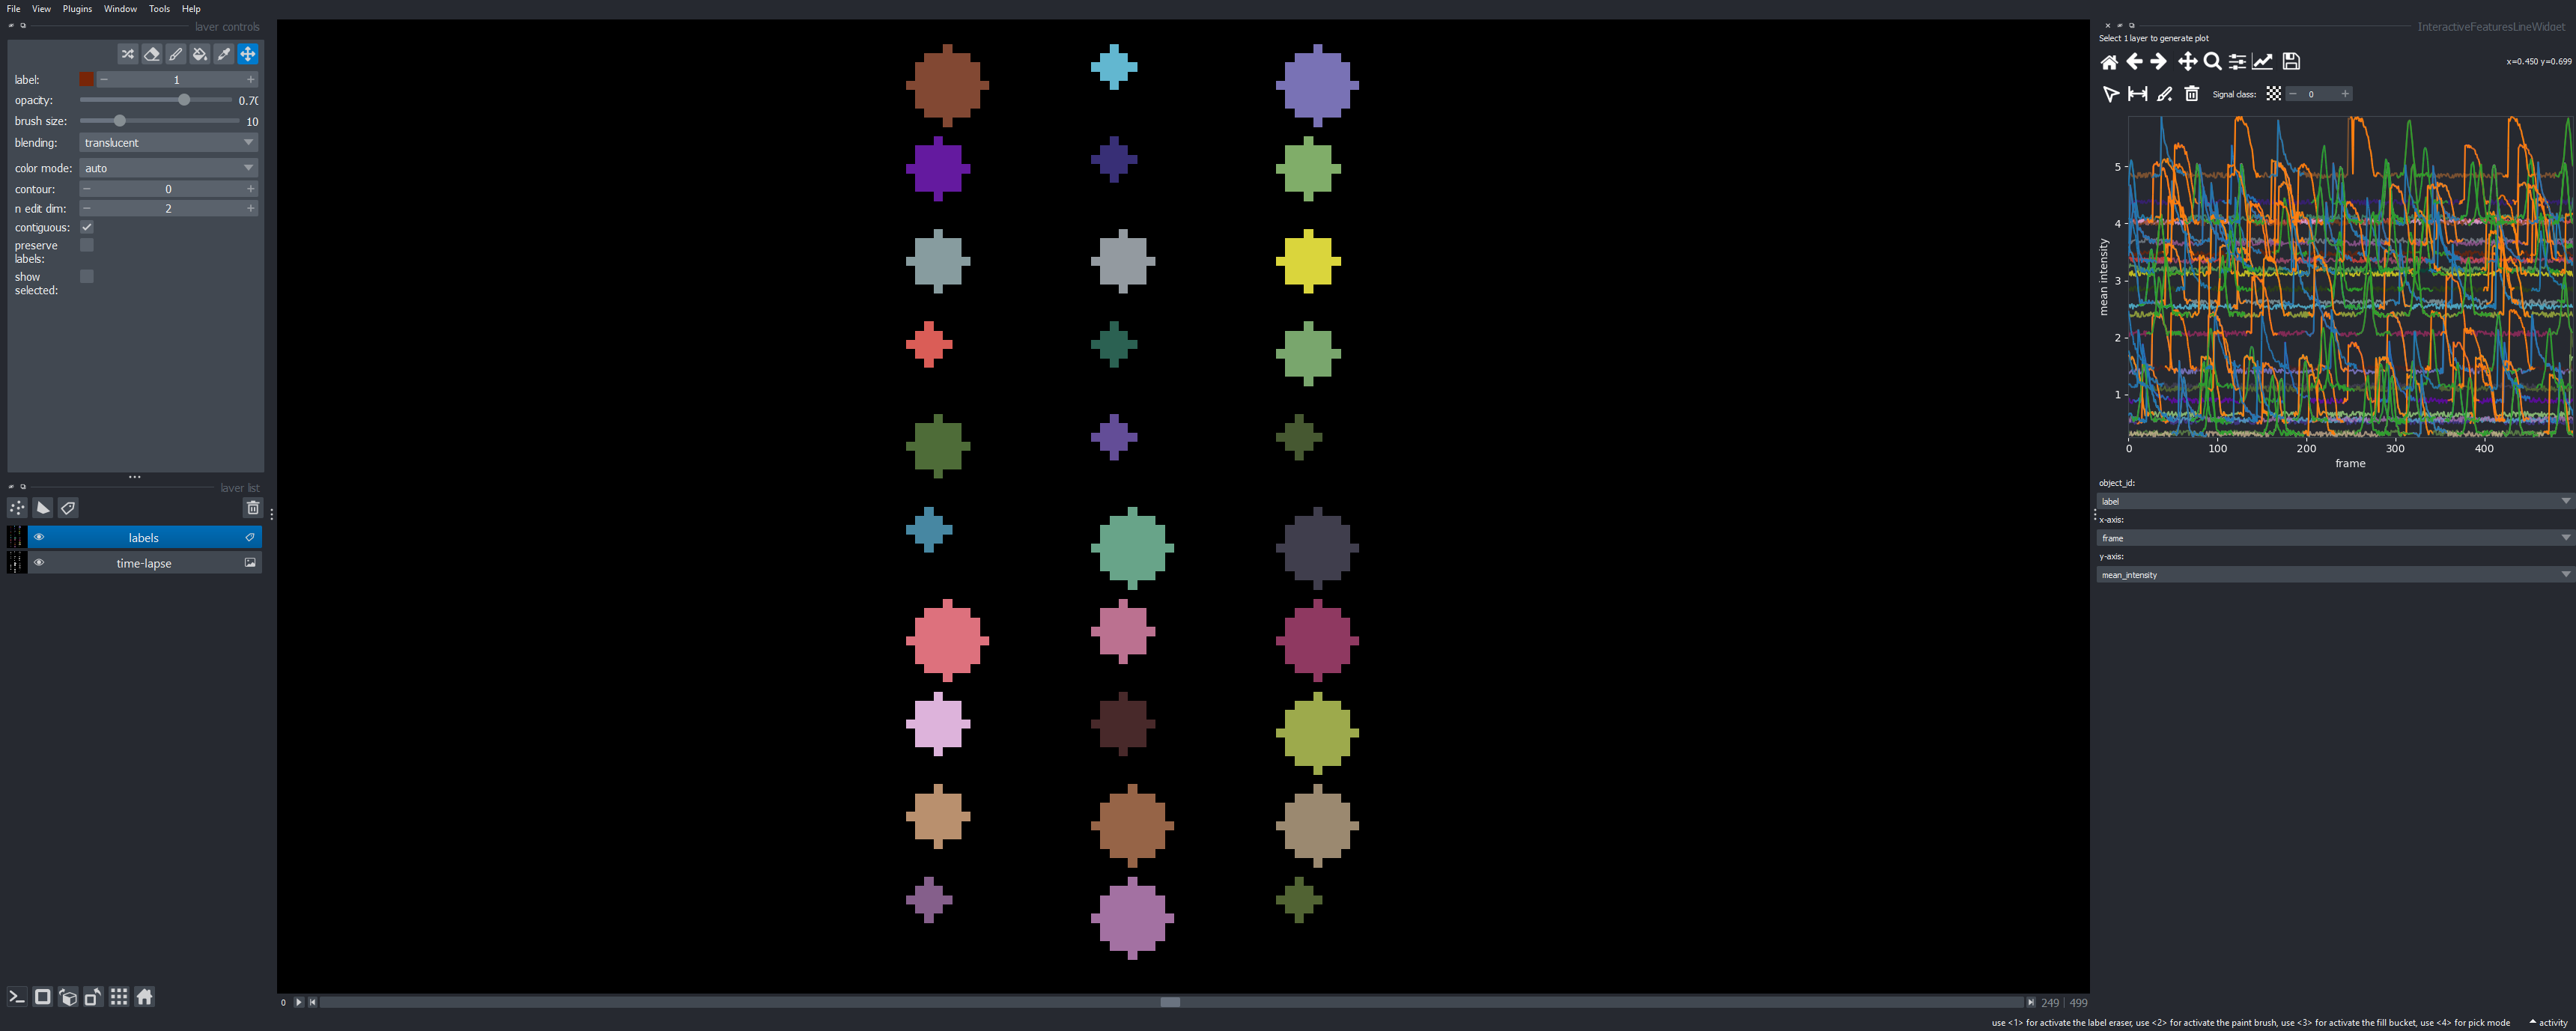

In [468]:
nbscreenshot(viewer)

# STOPPED HERE, things working up to above cell

In [ ]:
mapping = table_test_set.set_index(['original_label', 'frame'])['predicted_category']

In [322]:
tab['predicted_category']

37    3
0     2
38    3
1     2
39    3
2     2
Name: predicted_category, dtype: int64

In [318]:
categories = tab['predicted_category'].values
left_value = categories[0]
right_value = categories[-1]
    


In [319]:
categories

array([3, 2, 3, 2, 3, 2], dtype=int64)

In [ ]:
new_size = 

# Create the new array
new_array = np.empty(len(original_array) // 2, dtype=np.int64)

# Fill the first half with the first value of the original array
new_array[:new_size//2] = left_value

# Fill the second half with the second value of the original array
new_array[new_size//2:] = right_value

In [320]:
    # Fill from boundaries to center
    filled_categories = np.ones(categories, left_value)
    filled_categories[len(categories)//2:] = right_value

In [314]:
# Step 2: Handle Duplicates
def fill_duplicates(group):
    frames = group['frame'].values
    categories = group['predicted_category'].values
    left_value = categories[0]
    right_value = categories[-1]
    
    # Fill from boundaries to center
    filled_categories = np.full_like(categories, left_value)
    filled_categories[len(categories)//2:] = right_value
    return pd.Series(filled_categories, index=group.index)

# Apply the fill_duplicates function to each group of duplicates
filled_duplicates = duplicates.groupby(['original_label', 'frame']).apply(fill_duplicates).reset_index()
filled_duplicates

,original_label,frame,level_2,0
0,10,159,31,1
1,10,159,0,1
2,10,160,32,1
3,10,160,1,1
4,10,161,33,1
...,...,...,...,...
73,27,319,0,2
74,27,320,38,3
75,27,320,1,2
76,27,321,39,3


In [316]:
table_test_set.to_csv('table_test_set.csv')

In [317]:
# Update the original table_test_set with filled duplicates
table_test_set.update(filled_duplicates)
table_test_set.to_csv('table_test_set2.csv')

In [291]:
# Step 3: Map Predictions
mapping = table_test_set.set_index(['original_label', 'frame'])['predicted_category']
mapping.index.names = ['label', 'frame']
table2['predicted_category'] = table2[['label', 'frame']].apply(tuple, axis=1).map(mapping).fillna(0)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [290]:
duplicates = table_test_set[table_test_set.duplicated(subset=['original_label', 'frame'], keep=False)]
duplicates

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
0,3.507814,277009,10,39,73,159,0,1-2-3,1
1,3.501321,277009,10,39,73,159,0,1-2-3,1
2,3.461263,277009,10,39,73,160,0,1-2-3,1
3,3.425859,277009,10,39,73,160,0,1-2-3,1
4,3.453399,277009,10,39,73,161,0,1-2-3,1
...,...,...,...,...,...,...,...,...,...
34,1.098567,277269,16,405,443,17,0,2-3,2
35,1.182985,277269,16,405,443,17,0,2-3,2
36,1.116839,277269,16,405,443,18,0,2-3,2
37,1.160974,277269,16,405,443,18,0,2-3,2


In [270]:
mapping = table_test_set.set_index(['original_label', 'frame'])['predicted_category']
mapping.index.names = ['label', 'frame']
table2[['label', 'frame']].apply(tuple, axis=1).map(mapping)

original_label  frame
1               39       1
                40       1
                41       1
                42       1
                43       1
                        ..
30              439      2
                440      2
                441      2
                442      2
                443      2
Name: predicted_category, Length: 7047, dtype: int64

In [271]:
mapping.index.names = ['label', 'frame']
mapping.index.is_unique

False

In [281]:
duplicates = mapping.index[mapping.index.duplicated()]
print(duplicates)

MultiIndex([(10, 159),
            (10, 160),
            (10, 161),
            (10, 162),
            (11, 482),
            (11, 483),
            (11, 484),
            (11, 485),
            (11, 486),
            (11, 487),
            (11, 488),
            (16,  11),
            (16,  12),
            (16,  13),
            (16,  14),
            (16,  15),
            (16,  16),
            (16,  17),
            (16,  18),
            (19, 332),
            (19, 333),
            (19, 334),
            (19, 335),
            (19, 336),
            (19, 337),
            (24,  92),
            (24,  93),
            (24,  94),
            (24,  95),
            (24,  96),
            (24,  97),
            (24,  98),
            (24,  99),
            (24, 100),
            (24, 101),
            (24, 102),
            (27, 319),
            (27, 320),
            (27, 321)],
           names=['label', 'frame'])


In [282]:
mapping[duplicates]

label  frame
10     159      1
       159      1
       160      1
       160      1
       161      1
               ..
27     319      2
       320      3
       320      2
       321      3
       321      2
Name: predicted_category, Length: 78, dtype: int64

In [283]:
mapping

label  frame
1      39       1
       40       1
       41       1
       42       1
       43       1
               ..
30     439      2
       440      2
       441      2
       442      2
       443      2
Name: predicted_category, Length: 7047, dtype: int64

In [156]:
len(duplicates)

84

In [77]:
table2 = table.copy()

In [134]:
table2[['label', 'frame']].apply(tuple, axis=1)

True

In [133]:
# Sample Series with MultiIndex
index = pd.MultiIndex.from_tuples([('a', 1), ('a', 2), ('b', 1), ('b', 1)])
series = pd.Series([10, 20, 30, 40], index=index)

# Check if the index is unique
print(series.index.is_unique)

False


In [131]:
table2[['label', 'frame']].apply(tuple, axis=1).map(mapping)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [80]:
table2['Predictions'] = table2[['label', 'frame']].apply(tuple, axis=1).map(mapping)
table2

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [73]:
table

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,1,2,2.538447,0,0
2,2,3,1.398264,0,0
3,3,4,0.913758,0,0
4,4,5,0.505126,0,0
...,...,...,...,...,...
14995,14995,26,3.999081,499,0
14996,14996,27,0.277202,499,0
14997,14997,28,0.559926,499,0
14998,14998,29,3.634906,499,0


### Evaluate Results for one chosen label

In [81]:
current_label = 30

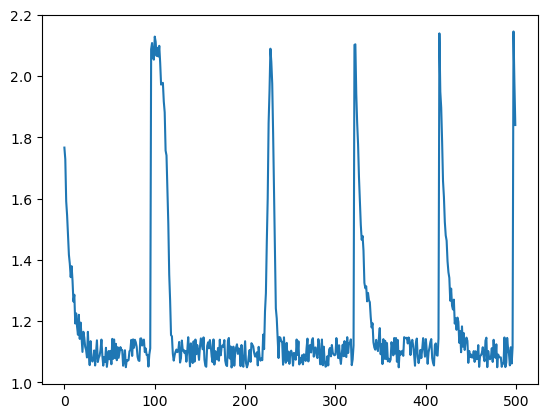

In [82]:
plt.plot(table[table['label'] == current_label]['mean_intensity'].values)

Group by sub_label to add predictions in a matched way

In [80]:
# first_row_grouped_by_sub_label = table_test_set.groupby('sub_label').first().reset_index()
# first_row_grouped_by_sub_label['predicted_category'] = predictions
# first_row_grouped_by_sub_label

Filter table by chosen label

In [83]:
current_label_sub_table = table_test_set[table_test_set['original_label'] == current_label]
current_label_sub_table

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
0,1.051735,343,30,93,124,93.0,0,1,1
1,1.091275,343,30,93,124,94.0,0,1,1
2,1.111204,343,30,93,124,95.0,0,1,1
3,2.087963,343,30,93,124,96.0,0,1,1
4,2.108055,343,30,93,124,97.0,0,1,1
...,...,...,...,...,...,...,...,...,...
17,1.140673,350,30,219,240,236.0,0,3,3
18,1.079643,350,30,219,240,237.0,0,3,3
19,1.148125,350,30,219,240,238.0,0,3,3
20,1.145647,350,30,219,240,239.0,0,3,3


In [94]:
def generate_slices(df, column_id, column_sort):
    """
    Generates a dictionary of slice objects for each unique value in the specified ID column of the DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to process.
    column_id : str
        The name of the column to use as the identifier (previously 'sub_label').
    column_sort : str
        The name of the column to sort by and create slices from (previously 'frame').

    Returns
    -------
    dict
        A dictionary where each key is a unique value from column_id and each value is a slice object
        representing the range of values from column_sort for that ID.

    Examples
    --------
    >>> df = pd.DataFrame({
    ...     'sub_label': [343, 343, 343, 343, 343, 350, 350, 350, 350, 350],
    ...     'frame': [93.0, 94.0, 95.0, 96.0, 97.0, 236.0, 237.0, 238.0, 239.0, 240.0]
    ... })
    >>> column_id = 'sub_label'
    >>> column_sort = 'frame'
    >>> slices_dict = generate_slices(df, column_id, column_sort)
    >>> print(slices_dict)
    """
    slices_dict = {}
    for id_value, group in df.groupby(column_id):
        start_frame = group[column_sort].min()
        stop_frame = group[column_sort].max() + 1  # Assuming you want to include the stop frame in the slice
        slices_dict[id_value] = slice(int(start_frame), int(stop_frame), 1)
    return slices_dict

In [95]:
slices_dict = generate_slices(current_label_sub_table, column_id='sub_label', column_sort='frame')
slices_dict

{343: slice(93, 125, 1),
 344: slice(0, 29, 1),
 345: slice(93, 125, 1),
 346: slice(222, 254, 1),
 347: slice(318, 350, 1),
 348: slice(412, 444, 1),
 349: slice(0, 15, 1),
 350: slice(219, 241, 1)}

In [96]:
def calculate_jaccard_index(slice1, slice2):
    range1 = set(range(slice1.start, slice1.stop))
    range2 = set(range(slice2.start, slice2.stop))
    intersection = len(range1.intersection(range2))
    union = len(range1.union(range2))
    return intersection / union if union else 0

def merge_slices(slice1, slice2):
    new_start = min(slice1.start, slice2.start)
    new_stop = max(slice1.stop, slice2.stop)
    return slice(new_start, new_stop)

def can_merge(slice1, slice2, threshold):
    return calculate_jaccard_index(slice1, slice2) > threshold

def merge_slices_if_possible(slices, threshold):
    merged = []
    while slices:
        current = slices.pop(0)
        for i, other in enumerate(slices):
            if can_merge(current, other, threshold):
                current = merge_slices(current, other)
                slices.pop(i)
                slices.insert(0, current)  # Re-insert at start to check new slice against all others again
                break
        else:  # No merge occurred
            merged.append(current)
    return merged

def get_merged_slices(slices, threshold):
    return merge_slices_if_possible(slices, threshold)


In [97]:
threshold = 0.5
slices = list(slices_dict.values())
merged_slices = get_merged_slices(slices, threshold)
merged_slices

[slice(93, 125, None),
 slice(0, 29, None),
 slice(219, 254, None),
 slice(318, 350, 1),
 slice(412, 444, 1)]

# Stopped here, disconsider cells below, the slice approach is much faster
- Next step is to make it work with dictionaries (check jaccard notebook for example) and decide how to handle merged sub_label slices.
- Apply classifier only after excluding duplicates like this.

(330.0, 351.0)

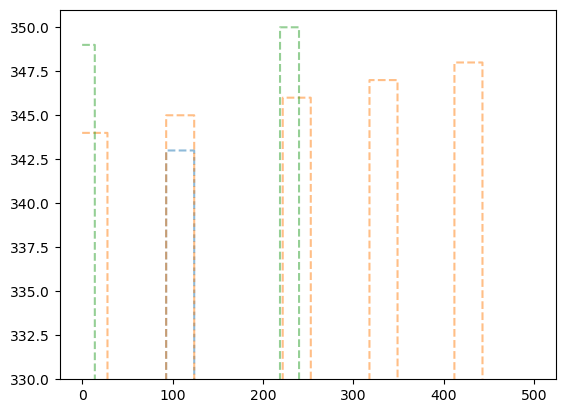

In [98]:
for arry in sub_label_array_list:
    plt.plot(arry, '--', alpha=0.5, )
plt.ylim(330, 351)

In [74]:
current_label_array_length = len(table[table['label'] == current_label]['mean_intensity'].values)
current_label_array_length

500

In [77]:
# Create a list of sub_label arrays for each template category
sub_label_array_list = []
current_label_array_length = len(table[table['label'] == current_label]['mean_intensity'].values)
for t_cat, sub_sub_table in list(current_label_sub_table.groupby('template_category')):
    print(sub_sub_table['frame'].values.astype(int))
    print(sub_sub_table['sub_label'].values)
    sub_label_array = np.zeros(current_label_array_length)
    sub_label_array[sub_sub_table['frame'].values.astype(int)] = sub_sub_table['sub_label'].values
    sub_label_array_list.append(sub_label_array)

[ 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124]
[343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343
 343 343 343 343 343 343 343 343 343 343 343 343 343 343]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 412
 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430
 431 432 433 434 435 436 437 438 439 440 441 442 443]
[344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344
 344 344 344 344 344 344 34

In [55]:
def calculate_jaccard_index(arrays):
    """
    Calculate the Jaccard index between a list of arrays representing sub-labels.

    Parameters
    ----------
    arrays : list
        A list of 1D arrays where each array represents time windows modulated by sub-labels values.
    
    Returns
    -------
    pd.DataFrame
        A DataFrame containing the Jaccard index between each pair of sub-label arrays.    
    """
    # Concatenate all arrays to identify unique window IDs and the total length
    concatenated = np.concatenate(arrays)
    unique_windows = np.unique(concatenated).astype(int)
    unique_windows = unique_windows[unique_windows > 0]  # Exclude 0, as it represents no window
    
    # Create a sparse matrix of shape (num_unique_windows, total_length)
    total_length = len(arrays[0])
    num_windows = len(unique_windows)
    window_to_index = {window: idx for idx, window in enumerate(unique_windows)}
    
    data = []
    rows = []
    cols = []
    
    for array in arrays:
        for time_point, window in enumerate(array):
            if window > 0:
                rows.append(window_to_index[window])
                cols.append(time_point)
                data.append(1)
    
    sparse_matrix = csr_matrix((data, (rows, cols)), shape=(num_windows, total_length))
    
    jaccard_results = []
    
    # Compare each pair of unique windows
    for i in range(num_windows):
        for j in range(i + 1, num_windows):
            # Find intersection and union
            intersection = sparse_matrix[i].multiply(sparse_matrix[j]).sum()
            union = sparse_matrix[i].maximum(sparse_matrix[j]).sum()
            
            if union > 0:
                jaccard_index = intersection / union
                if intersection > 0:  # Only consider overlapping windows
                    window1 = unique_windows[i]
                    window2 = unique_windows[j]
                    jaccard_results.append((window1, window2, jaccard_index))
    
    # Convert results to a DataFrame
    jaccard_df = pd.DataFrame(jaccard_results, columns=['sub_label_A', 'sub_label_B', 'JaccardIndex'])
    
    return jaccard_df

(330.0, 351.0)

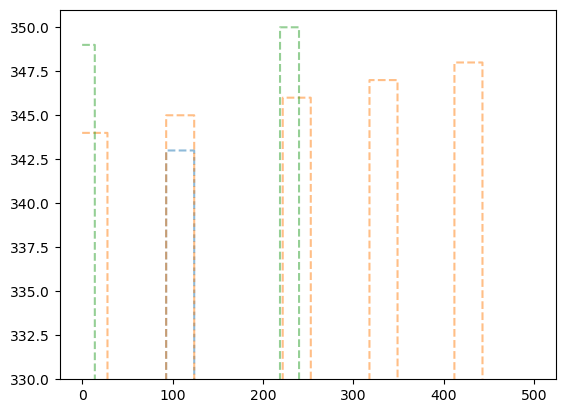

In [70]:
for arry in sub_label_array_list:
    plt.plot(arry, '--', alpha=0.5, )
plt.ylim(330, 351)


In [56]:
sub_labels_overlap_table = calculate_jaccard_index(sub_label_array_list)
sub_labels_overlap_table

,sub_label_A,sub_label_B,JaccardIndex
0,343,345,1.000000
1,344,349,0.517241
2,346,350,0.542857


In [57]:
# Add column with counts of unique sub-labels-a
sub_labels_overlap_table['sub_label_A_count'] = sub_labels_overlap_table['sub_label_A'].map(sub_labels_overlap_table['sub_label_A'].value_counts())
sub_labels_overlap_table

,sub_label_A,sub_label_B,JaccardIndex,sub_label_A_count
0,343,345,1.000000,1
1,344,349,0.517241,1
2,346,350,0.542857,1


## Stopped here
If prediction_a has more counts, it means its window overlaps with more than 1 category, so prediction b values must be store ina  list to later check which classifier predictions were made and make a decision. Otherwise, i.e., if only one overlap with a different category occured, then check only that other sub_label prediction and make a decision. If both predictions agree, assign that class to the longest sub_label and remove the other(s). If they disagree, add a new category for the predicitons and a new columns on the table should tell which categories disagree, so it will up to the uswer to notice there is a new category and decide what to do with it.

In [85]:
jaccard_threshold = 0.5
sub_label_overlap_mask = sub_labels_overlap_table['JaccardIndex'] > jaccard_threshold

# Get predicted_values for each sub_label
sub_labels_overlap_table.sort_values(by='sub_label_A', ascending=True, inplace=True)
sub_label_A_array = sub_labels_overlap_table[sub_label_overlap_mask]['sub_label_A'].values
sub_label_B_array = sub_labels_overlap_table[sub_label_overlap_mask]['sub_label_B'].values
sub_label_A_counts_array = sub_labels_overlap_table[sub_label_overlap_mask]['sub_label_A_count'].values
prediction_b_list = []
for a, b, a_counts in zip(sub_label_A_array, sub_label_B_array, sub_label_A_counts_array):
    print(a, b)
    prediction_a = current_label_sub_table[current_label_sub_table['sub_label'] == a]['predicted_category'].values[0]
    if a_counts > 1:
        prediction_b = current_label_sub_table[current_label_sub_table['sub_label'] == b]['predicted_category'].values[0]
        prediction_b_list.append(prediction_b)
    else:




343 345
344 349
346 350


In [58]:
import numpy as np
from scipy.sparse import csr_matrix

def calculate_jaccard_index(arrays):
    """
    Calculates the Jaccard index for pairs of overlapping time windows.
    
    Parameters:
    arrays (list of np.array): A list of 1D arrays where each array represents time windows.
    
    Returns:
    list of tuples: Each tuple contains two window ids and their Jaccard index.
    """
    # Concatenate all arrays to identify unique window IDs and the total length
    concatenated = np.concatenate(arrays)
    unique_windows = np.unique(concatenated)
    unique_windows = unique_windows[unique_windows > 0]  # Exclude 0, as it represents no window
    
    # Create a sparse matrix of shape (num_unique_windows, total_length)
    total_length = len(arrays[0])
    num_windows = len(unique_windows)
    window_to_index = {window: idx for idx, window in enumerate(unique_windows)}
    
    data = []
    rows = []
    cols = []
    
    for array in arrays:
        for time_point, window in enumerate(array):
            if window > 0:
                rows.append(window_to_index[window])
                cols.append(time_point)
                data.append(1)
    
    sparse_matrix = csr_matrix((data, (rows, cols)), shape=(num_windows, total_length))
    
    jaccard_results = []
    
    # Compare each pair of unique windows
    for i in range(num_windows):
        for j in range(i + 1, num_windows):
            # Find intersection and union
            intersection = sparse_matrix[i].multiply(sparse_matrix[j]).sum()
            union = sparse_matrix[i].maximum(sparse_matrix[j]).sum()
            
            if union > 0:
                jaccard_index = intersection / union
                if intersection > 0:  # Only consider overlapping windows
                    window1 = unique_windows[i]
                    window2 = unique_windows[j]
                    jaccard_results.append((window1, window2, jaccard_index))
    
    return jaccard_results

# Example usage
array1 = np.array([0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0])
array2 = np.array([3, 3, 0, 0, 0, 4, 4, 0, 0, 0, 0, 5, 5, 5, 5])
array3 = np.array([0, 0, 0, 0, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0])

results = calculate_jaccard_index([array1, array2, array3])
for result in results:
    print(f"Window {result[0]} and Window {result[1]} have a Jaccard index of {result[2]:.4f}")


Window 1 and Window 4 have a Jaccard index of 0.6667
Window 1 and Window 6 have a Jaccard index of 1.0000
Window 2 and Window 5 have a Jaccard index of 0.3333
Window 4 and Window 6 have a Jaccard index of 0.6667


In [59]:
current_label_sub_table.groupby('template_category')

In [60]:
current_label_sub_table = first_row_grouped_by_sub_label[first_row_grouped_by_sub_label['original_label'] == current_label]
current_label_sub_table

,sub_label,mean_intensity,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
342,343,1.051735,30,93,124,93.0,0,1,1
343,344,1.766683,30,0,28,0.0,0,2,2
344,345,1.051735,30,93,124,93.0,0,2,1
345,346,1.231819,30,222,253,222.0,0,2,2
346,347,1.056382,30,318,349,318.0,0,2,2
347,348,1.088830,30,412,443,412.0,0,2,2
348,349,1.766683,30,0,14,0.0,0,3,2
349,350,1.072567,30,219,240,219.0,0,3,3


Get intersection and union of sub_labels in chosen label

In [78]:
sub_label_array_list = []
categories_list = []
# every label may have a different length
# currently testing for last label (30)
current_label_array_length = len(df[df['label'] == current_label]['mean_intensity'].values)
overlap_array = []
for t_cat, sub_sub_table in list(current_label_sub_table.groupby('template_category')):
    sub_label_array = np.zeros(current_label_array_length)
    for i, row in sub_sub_table.iterrows():
        sub_label_array[int(row['original_start_frame']):int(row['original_end_frame'])] = row['sub_label']
    overlap_array.append(sub_label_array.astype(bool))
    sub_label_array_list.append(sub_label_array)
    categories_list.append(t_cat)
intersection_array = np.sum(np.array(overlap_array).astype(int), axis=0) > 1
union_array = np.sum(np.array(overlap_array).astype(int), axis=0) > 0

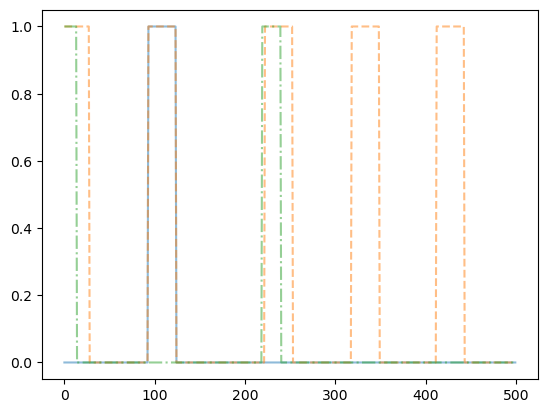

In [79]:
plt.plot(overlap_array[0], alpha=0.5)
plt.plot(overlap_array[1], '--', alpha=0.5)
plt.plot(overlap_array[2], '-.', alpha=0.5)

In [80]:
def get_windows_onsets_and_lengths(overlap_array):
    transition_indices = np.where(
        np.concatenate(
            ([overlap_array[0]], overlap_array[:-1] != overlap_array[1:], [True])
            )
            )[0]
    onsets = transition_indices[:-1:2]
    overlap_lengths = np.diff(transition_indices)[::2]
    return onsets, overlap_lengths

In [81]:
intersection_onsets, intersection_lengths = get_windows_onsets_and_lengths(intersection_array)
union_onsets, union_lengths = get_windows_onsets_and_lengths(union_array)

In [82]:
union_onsets

array([  0,  93, 219, 318, 412], dtype=int64)

In [83]:
union_lengths

array([28, 31, 34, 31, 31], dtype=int64)

In [84]:
intersection_lengths

array([14, 31, 18], dtype=int64)

In [85]:
intersection_onsets

array([  0,  93, 222], dtype=int64)

## Stopped here
Next steps:
- find a way to calculate jaccard index of overlapping sub_signals
- consider sub_labels where jaccard index is higher than threshold as duplicates
  - define a final category for them based on predicitons (if predictions disagree, think what to do...)


In [189]:
sub_label_interse_onsets_list = []
for sub_label_array in sub_label_array_list:
    sub_label_overlap_onsets_list.append(sub_label_array[overlap_onsets])

In [190]:
sub_label_overlap_onsets_list

[array([  0., 343.,   0.]),
 array([344., 345., 346.]),
 array([349.,   0., 350.])]

In [201]:
for values in zip(*sub_label_overlap_onsets_list, overlap_lengths):
    overlap_length = values[-1]
    sub_labels = np.array(values[:-1])
    print(sub_labels)
    sub_labels_that_overlap = sub_labels[sub_labels != 0]
    print(sub_labels_that_overlap)

[  0. 344. 349.]
[344. 349.]
[343. 345.   0.]
[343. 345.]
[  0. 346. 350.]
[346. 350.]


In [158]:
sub_label_array_in_category_dict[1][overlap_onsets]

array([  0., 343.,   0.])

In [159]:
sub_label_array_in_category_dict[2][overlap_onsets]

array([344., 345., 346.])

In [160]:
sub_label_array_in_category_dict[3][overlap_onsets]

array([349.,   0., 350.])

In [162]:
overlap_lengths

array([14, 31, 18], dtype=int64)

In [137]:
overlap_array = np.sum(np.array(overlap_array).astype(int), axis=0) > 1
np.count_nonzero(overlap_array)

array([63], dtype=int64)

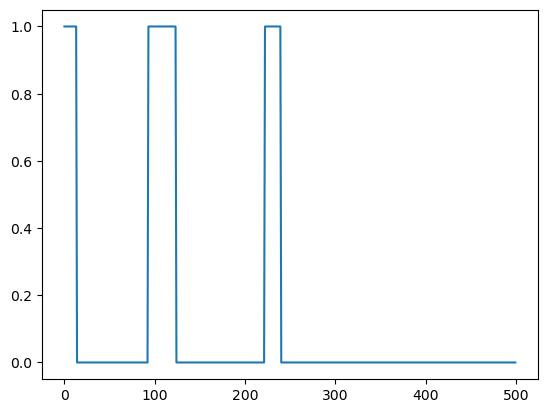

In [144]:
plt.plot(overlap_array)
plt.plot([])

In [139]:
np.concatenate(
            ([overlap_array[0]], overlap_array[:-1] != overlap_array[1:], [True])
            )

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,

In [145]:
np.where(
        np.concatenate(
            ([overlap_array[0]], overlap_array[:-1] != overlap_array[1:], [True])
            )
            )[0]

array([  0,  14,  93, 124, 222, 240, 500], dtype=int64)

In [141]:
np.diff(
    np.where(
        np.concatenate(
            ([overlap_array[0]], overlap_array[:-1] != overlap_array[1:], [True])
            )
            )[0])[::2]

array([14, 31, 18], dtype=int64)

In [140]:
import numpy as np

def count_consecutive_trues(boolean_array):
    # Ensure the input is a numpy array
    boolean_array = np.asarray(boolean_array)
    
    # Find the positions where the value changes
    changes = np.diff(boolean_array.astype(int))
    
    # Identify the start positions (+1 indicates start of True sequence)
    start_positions = np.where(changes == 1)[0] + 1
    
    # Identify the end positions (+1 indicates end of True sequence)
    end_positions = np.where(changes == -1)[0] + 1
    
    # If the array starts with True, prepend 0 to start_positions
    if boolean_array[0]:
        start_positions = np.r_[0, start_positions]
    
    # If the array ends with True, append the last index to end_positions
    if boolean_array[-1]:
        end_positions = np.r_[end_positions, len(boolean_array)]
    
    # Calculate the lengths of True sequences
    lengths = end_positions - start_positions
    
    return start_positions, lengths

# Example usage
# boolean_array = np.array([False, True, True, False, True, True, True, False, False, True, True])
start_positions, lengths = count_consecutive_trues(overlap_array)

print("Start positions of consecutive True values:", start_positions)
print("Lengths of consecutive True values:", lengths)


Start positions of consecutive True values: [  0  93 222]
Lengths of consecutive True values: [14 31 18]


In [ ]:
# store labels where overlap is larger than

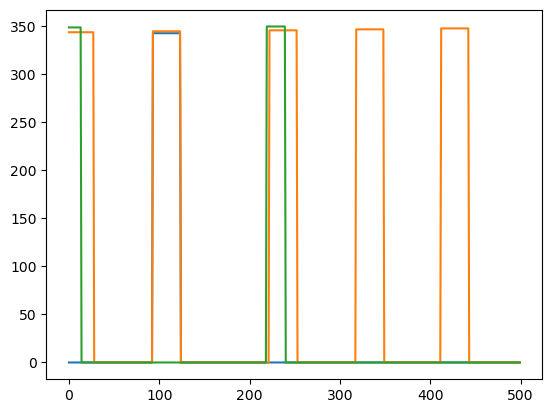

In [111]:
for k, v in sub_label_array_in_category_dict.items():
    
    plt.plot(v, label=f'Template Category {k}')
plt.legend()

In [92]:
sub_sub_table

,sub_label,mean_intensity,original_label,original_start_frame,original_end_frame,frame,cross_corr_peak,category,template_category,predicted_category
342,343,1.051735,30,93,124,93.0,109,0,1,1


In [97]:
predictions[-20:]

array([2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 3, 2, 2],
      dtype=int64)

Idea
- Expand predicitons column to fill whole table
- For each time-point in each label, give a weighted vote to the category of that time-point based on the predictions (give higher weight to matching detections)

In [77]:
df_resampled['predictions'] = predictions
df_resampled

ValueError: Length of values (469) does not match length of index (12940)

In [ ]:
viewer = napari.Viewer()
# averages = np.mean(time_lapse, axis=(1, 2))
# viewer.add_image(time_lapse, name='time-lapse')
# table = df

# viewer.add_labels(label_image, features=table, name='labels')

## Get all windows where there is a high cross-correlation peak, calculate the same features and add them to the table with annotation class 0

Display wavelet coefficients for each signal

In [23]:
len(signals_by_class[1][0])

31

In [24]:
# First signal of class 1 = signals_by_class[1][0]
waveletname = 'db4'
# Get max level of discrete wavelet
max_level_of_decomposition = pywt.dwt_max_level(len(signals_by_class[1][0]), waveletname)
print(max_level_of_decomposition)


2


In [25]:
def make_list_of_coefficients_names(waveletname, max_level_of_decomposition):
    list_coefficients_names = [waveletname + '_cA_' + str(max_level_of_decomposition)]
    list_coefficients_names += [waveletname + '_cD_' + str(i) for i in range(max_level_of_decomposition, 0, -1)]
    return list_coefficients_names

In [26]:
list_wavelet_coefficients = pywt.wavedec(signals_by_class[1][0], waveletname, level=max_level_of_decomposition)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients

[array([8.45641474, 7.2552391 , 9.22873853, 7.6903417 , 7.88126519,
        8.9506319 , 8.90890409, 8.7053209 , 8.47328454, 7.62091933,
        7.04237105, 6.95136322, 6.93967763]),
 array([-0.20218199, -0.5755312 ,  0.53312635, -0.1546327 , -0.00538744,
        -0.00606577, -0.00172286, -0.08456947,  0.08235799, -0.02600053,
         0.00195876, -0.03983206,  0.09999511]),
 array([ 0.17354602,  0.44541506, -0.19104386,  0.02377394, -0.01103984,
        -0.02120041, -0.01753815, -0.04454506, -0.02139769, -0.03030507,
         0.02486697,  0.02785961, -0.04129259, -0.01551608,  0.01455138,
        -0.01677421,  0.01666999, -0.01807835,  0.03788132])]

In [27]:
max_level_of_decomposition2 = pywt.dwt_max_level(len(signals_by_class[2][0]), waveletname)
list_wavelet_coefficients2 = pywt.wavedec(signals_by_class[2][0], waveletname, level=max_level_of_decomposition2)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients2

[array([6.37210044, 5.12964851, 4.92683402, 4.73878252, 6.08285418,
        6.02193842, 5.74626209, 5.55677173, 5.41862906, 5.27895748,
        5.20888182, 5.12791821, 5.07815693, 5.07919989, 5.00735282,
        4.98822024, 4.9938421 ]),
 array([ 0.00345871, -0.20618825, -0.14741952,  0.04519063, -0.03351969,
         0.01250238, -0.03145126,  0.03370468, -0.02882155,  0.06726776,
        -0.01056376, -0.0132997 , -0.03085401,  0.01007453, -0.00215131,
         0.03468431,  0.00574862])]

In [28]:
max_level_of_decomposition3 = pywt.dwt_max_level(len(signals_by_class[3][0]), waveletname)
list_wavelet_coefficients3 = pywt.wavedec(signals_by_class[3][0], waveletname, level=max_level_of_decomposition3)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients3

[array([5.14557137, 4.96795388, 4.98439313, 4.95892554, 5.00320784,
        5.40136415, 5.87769501, 6.26405175, 6.14095473, 5.61898848,
        5.1713838 , 4.95077739, 4.9455709 , 4.90906561]),
 array([-0.015589  , -0.03433065,  0.02128308,  0.0474797 , -0.00886253,
        -0.03256189,  0.00784702, -0.02863592,  0.00967588, -0.02761624,
         0.03052726, -0.0131998 , -0.01783538,  0.03166538])]

Plot of coefficients for db4 decomposition of signal class 1 (cardiac AP)

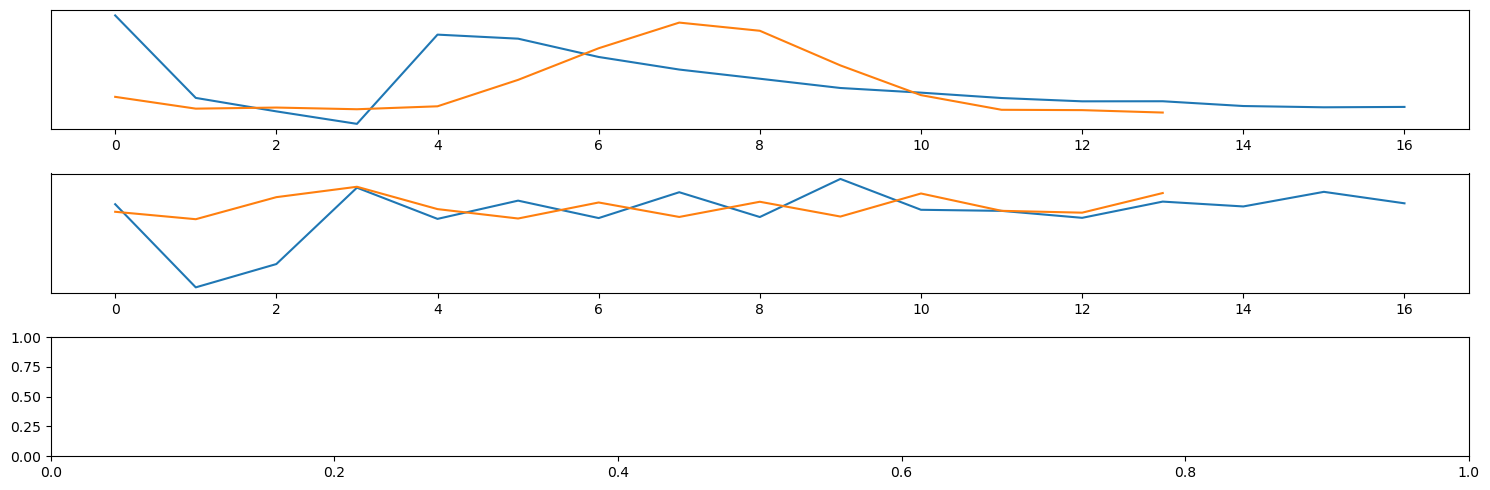

In [30]:
fig, ax = plt.subplots(max_level_of_decomposition + 1, 1, figsize=(15,5))
i=1
# for j, coef in zip(range(len(list_wavelet_coefficients)), list_wavelet_coefficients):
#     # First level is the approximation
#     if j == 0:
#         ax[j].plot(coef, label='label: ' + str(i))
#         ax[j].set_title('Approximation Coefficient.')
#     else:
#         ax[j].plot(coef, label='label: ' + str(i))
#         ax[j].set_title('Detail Coefficient: level ' + str(j) + '.')
#     ax[j].set_yticks([])

for j, coef in zip(range(len(list_wavelet_coefficients2)), list_wavelet_coefficients2):
    # First level is the approximation
    if j == 0:
        ax[j].plot(coef, label='label: ' + str(i))
    else:
        ax[j].plot(coef, label='label: ' + str(i))
    ax[j].set_yticks([])

for j, coef in zip(range(len(list_wavelet_coefficients3)), list_wavelet_coefficients3):
    # First level is the approximation
    if j == 0:
        ax[j].plot(coef, label='label: ' + str(i))
    else:
        ax[j].plot(coef, label='label: ' + str(i))
    ax[j].set_yticks([])

plt.tight_layout()

In [ ]:
a=1

In [ ]:

list_of_coeff_features_table = []
# Get features from wavelet coefficients
for coeff, decomp_level_name in zip(list_wavelet_coefficients, list_of_wavelet_decomposition_level_names):
    coeff_table = pd.DataFrame(coeff, index=signals_table.index)
    coeff_features_table = get_signal_features_table(coeff_table)
    coeff_features_table.columns = [decomp_level_name + '_' +
                                    column_name for column_name in coeff_features_table.columns]
    coeff_features_table.reset_index(inplace=True)
    list_of_coeff_features_table.append(coeff_features_table)

In [60]:
# Get training data
# table_training = table[table['Annotations'] > 0]
# Reshape table, storing one signal per row
signals_table_training = table_training.pivot(
    index='label',
    columns='frame',
    values='mean_intensity')

- get signals with annotations (DONE, currently filtering by specific label ID (to get noise parts as well))
  - get short-signals separated by class (DONE in `signal_by_class`)

  - calculate cross-correlations with composite signal(s) (DONE with one example above)

- caculate wavelets for short-signals

  - calculate cross-correlations of each short-signal decomposition level with corresponding decomposition level of composite signal(s)


- consider thrsholding or features to find potential matches
